# CLOUDY workshop

In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simpson
from itertools import product

# if you have Mac with retina display (if not: delete next line)
%config InlineBackend.figure_format = 'retina'

# useful constants
pc = 3.086e18 # cm
msun = 1.99e33 # grams
lsun = 3.9e33 # erg/s
c_cms = 2.99792458e10 # cm/s
ry_ev = 13.605698 # eV in 1 Rydberg
ry_hz = 3.2898e+15 # Hz in 1 Rydberg
ry_nm = 91.1270 # nm in 1 Rydberg

# plot options
sns.set_style('ticks')
sns.set_style({'xtick.direction': 'in', 'ytick.direction': 'in'})
sns.set_context('paper', rc={'font.size':10, 'axes.titlesize':12, 
    'axes.labelsize':10, 'xtick.labelsize':10, 'ytick.labelsize':10,
    'xtick.minor.size': 0, 'ytick.minor.size': 0})
sns.set_palette('colorblind')

# double check we are using the correct virtual environment
print('Jupyter is using the %s kernel' % os.path.basename(sys.executable.replace('/bin/python','')))

# to know the current location
print('Present working directory is %s' % os.getcwd())

Jupyter is using the claudia kernel
Present working directory is /Users/fesposito/astro/output/teach/unibo_ism_2025/cloudy_unibo_workshop/notebooks


# PDR simulation

In [311]:
prefix = '../pdr/pdr5_h400_g300'
#prefix = '../xdr/agn2_h400_x000'

## Continuum file

In [312]:
# import files and print column names
cont = pd.read_csv(prefix + '.cont', sep='\t')
print(cont.columns.to_numpy())

['#Cont  nu' 'incident' 'trans' 'DiffOut' 'net trans' 'reflc' 'total'
 'reflin' 'outlin' 'lineID' 'cont' 'nLine']


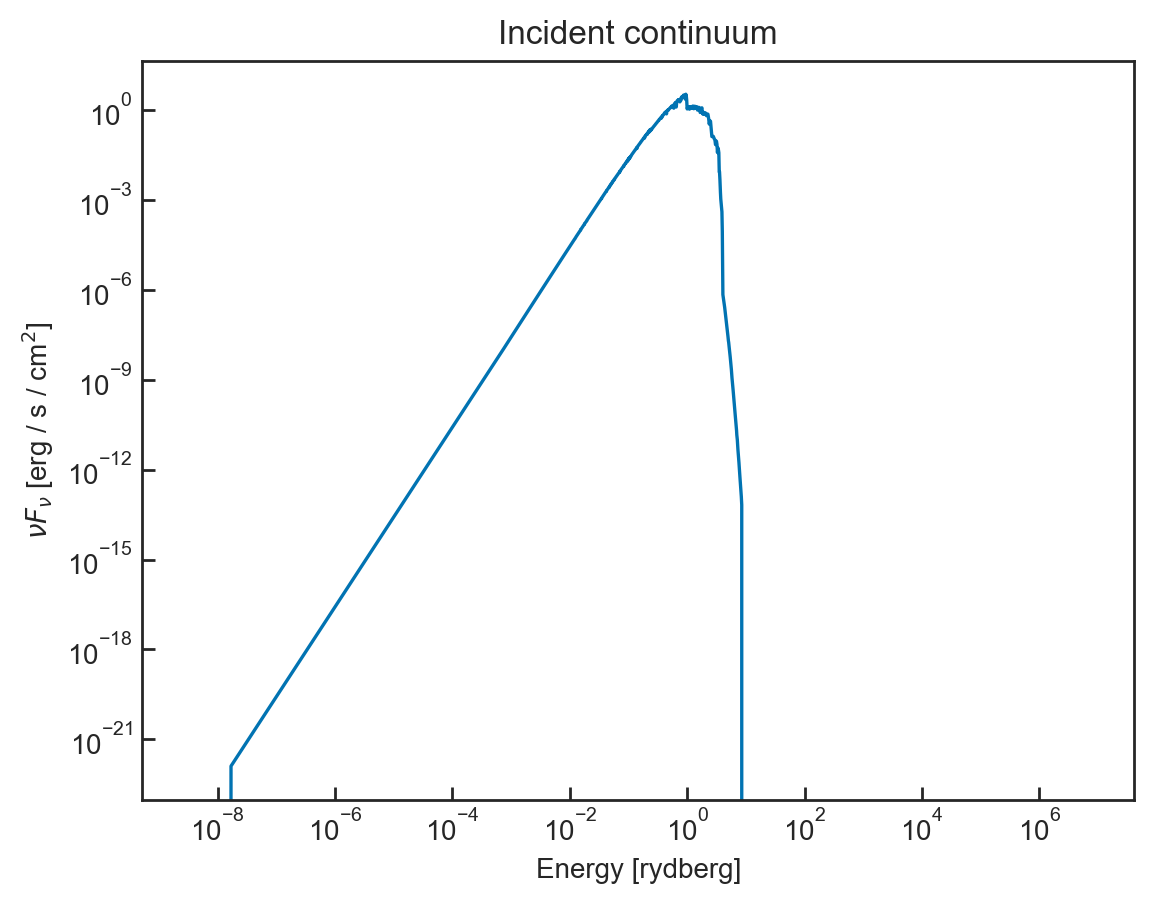

In [255]:
x = cont['#Cont  nu']
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Energy [rydberg]')
ax.set_ylabel(r'$\nu F_{\nu}$ [erg / s / cm$^2$]');
#ax.set_ylim(bottom=1e-7)
#ax.set_xlim([1e-2, 1e1]);

#### Change to energy in eV

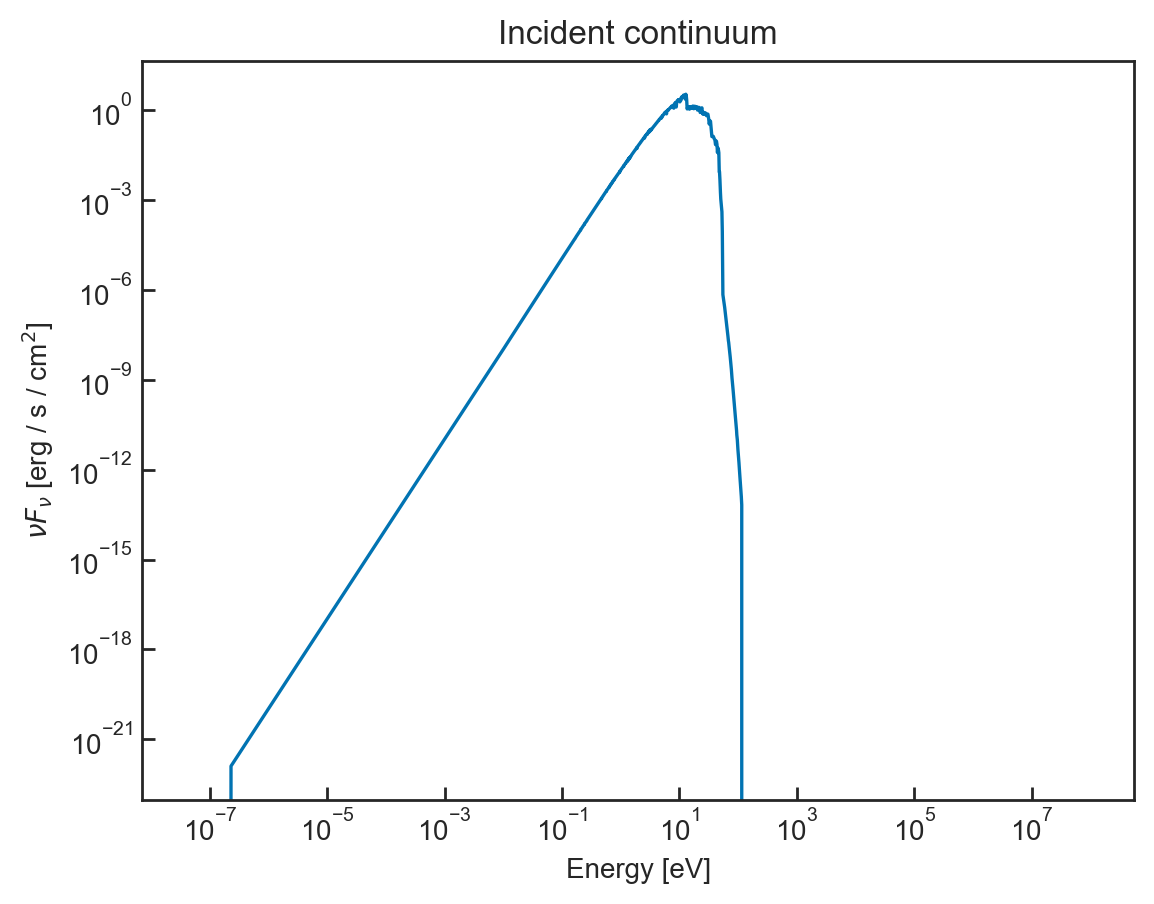

In [256]:
x = cont['#Cont  nu'] * ry_ev
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel(r'$\nu F_{\nu}$ [erg / s / cm$^2$]');
#ax.set_ylim(bottom=1e-7)
#ax.set_xlim([3e-1, 1e2]);
#ax.axvspan(6, 13.6, fc='gray', ls='none', alpha=.1);

#### Check the integrated flux

In [257]:
energy_ev = cont['#Cont  nu'] * ry_ev
fuv = (energy_ev >= 6) & (energy_ev <= 13.6)
x = energy_ev[fuv]
y = cont['incident'][fuv] / x
flux_integral = simpson(y, x=x)
print('FUV flux is %.2e erg/s/cm^2 = %.1f in G0 units' % (flux_integral, flux_integral / 1.6e-3))

FUV flux is 1.58e+00 erg/s/cm^2 = 986.3 in G0 units


#### Change to wavelength

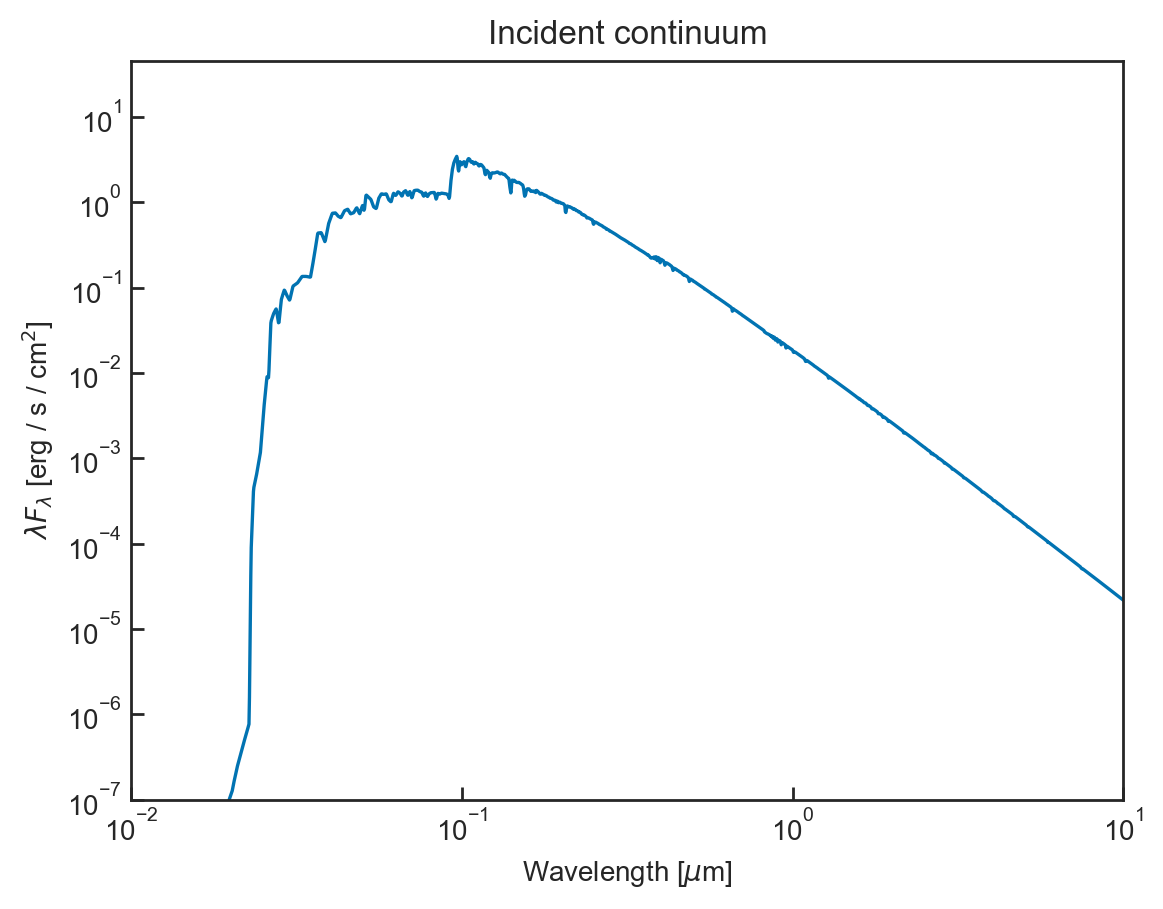

In [258]:
x = ry_nm / cont['#Cont  nu'] / 1e3
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$\lambda F_{\lambda}$ [erg / s / cm$^2$]')
ax.set_ylim(bottom=1e-7)
ax.set_xlim([1e-2, 1e1]);

### Continuum radiation from the cloud

Columns of interest:
- `trans`: transmitted incident continuum and does not include diffuse emission from the cloud
- `DiffOut`: outward portion of the emitted continuum and line emission, does not include the attenuated or reflected emission
- `net trans`: net transmitted continuum = `trans` + `DiffOut`
- `reflc`: reflected continuum
- `total`: `net trans` + `reflc`
- `reflin`: sum of all reflected line emission
- `outlin`: sum of all outward line emission

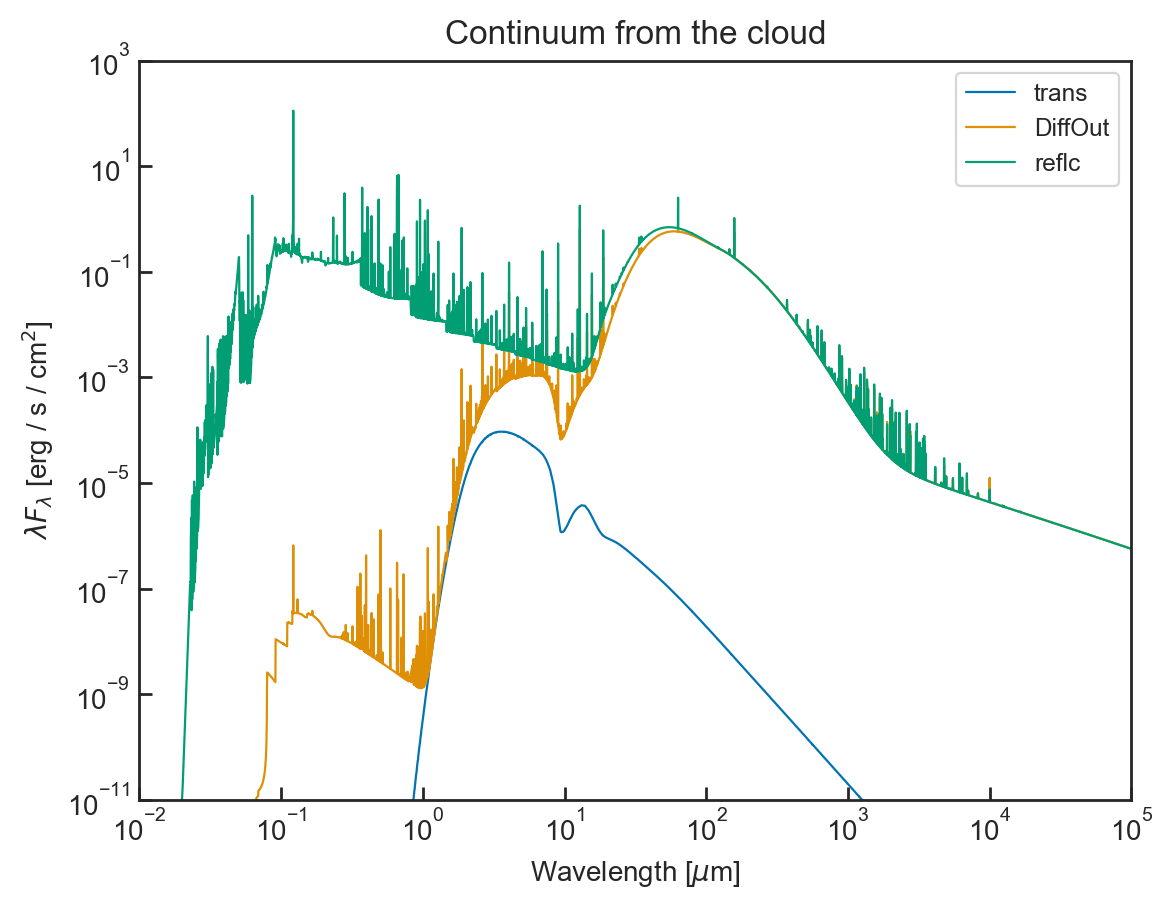

In [259]:
x = ry_nm / cont['#Cont  nu'] / 1e3
ys = ['trans', 'DiffOut', 'reflc']

fig, ax = plt.subplots(1, 1)
ax.set_title('Continuum from the cloud')

for y in ys:
    ax.loglog(x, cont[y], label=y, lw=.8)

ax.legend()
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$\lambda F_{\lambda}$ [erg / s / cm$^2$]')
ax.set_ylim([1e-11, 1e3])
ax.set_xlim([1e-2, 1e5]);
#ax.loglog(x, cont['incident'], label='incident', c='k', lw=.8);

## OVR and PDR files

**OVR** columns:
- `#depth`: cloud depth [cm]
- `Te`: temperature [K]
- `Htot`: local heating [erg / s / cm$^3$]
- `hden`: total hydrogen density [cm$^{-3}$]
- `eden`: electron density [cm$^{-3}$]
- `2H_2/H`: fraction of molecular hydrogen
- `HI`: fraction of neutral hydrogen
- `HII`: fraction of ionized hydrogen
- `CO/C`: fraction of carbon in CO
- `C1`: fraction of neutral carbon
- `C2`: fraction of carbon ionized 1 time

**PDR** new columns:
- `H colden`: total hydrogen column density [cm$^{-2}$]
- `G0`: internal FUV field [$1.6 \times 10^{-3}$ erg / s / cm$^2$]

In [313]:
# import files and print column names
ovr = pd.read_csv(prefix + '.ovr', sep='\t')
pdr = pd.read_csv(prefix + '.pdr', sep='\t')

### Gas temperature

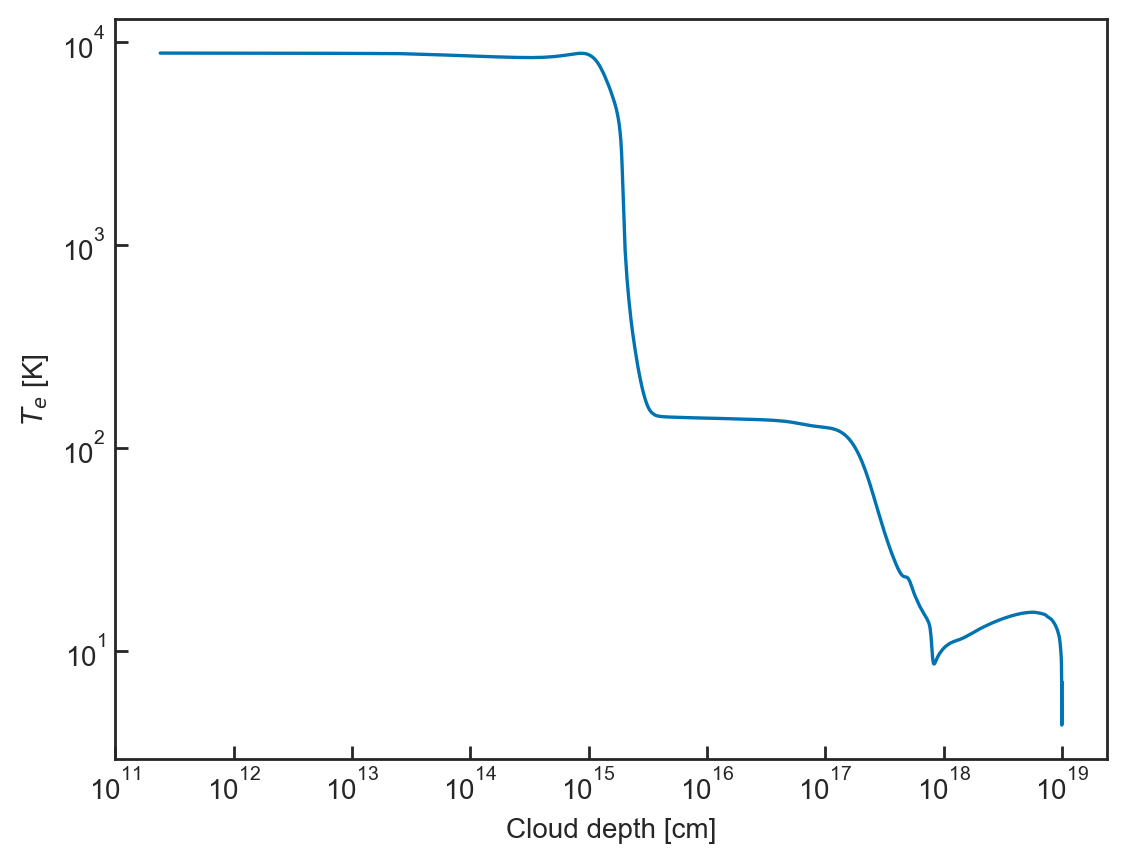

In [261]:
x = ovr['#depth']
y = ovr['Te']

fig, ax = plt.subplots(1, 1)
ax.loglog(x, y)
ax.set_xlabel('Cloud depth [cm]')
ax.set_ylabel('$T_e$ [K]');

### Ionization fractions

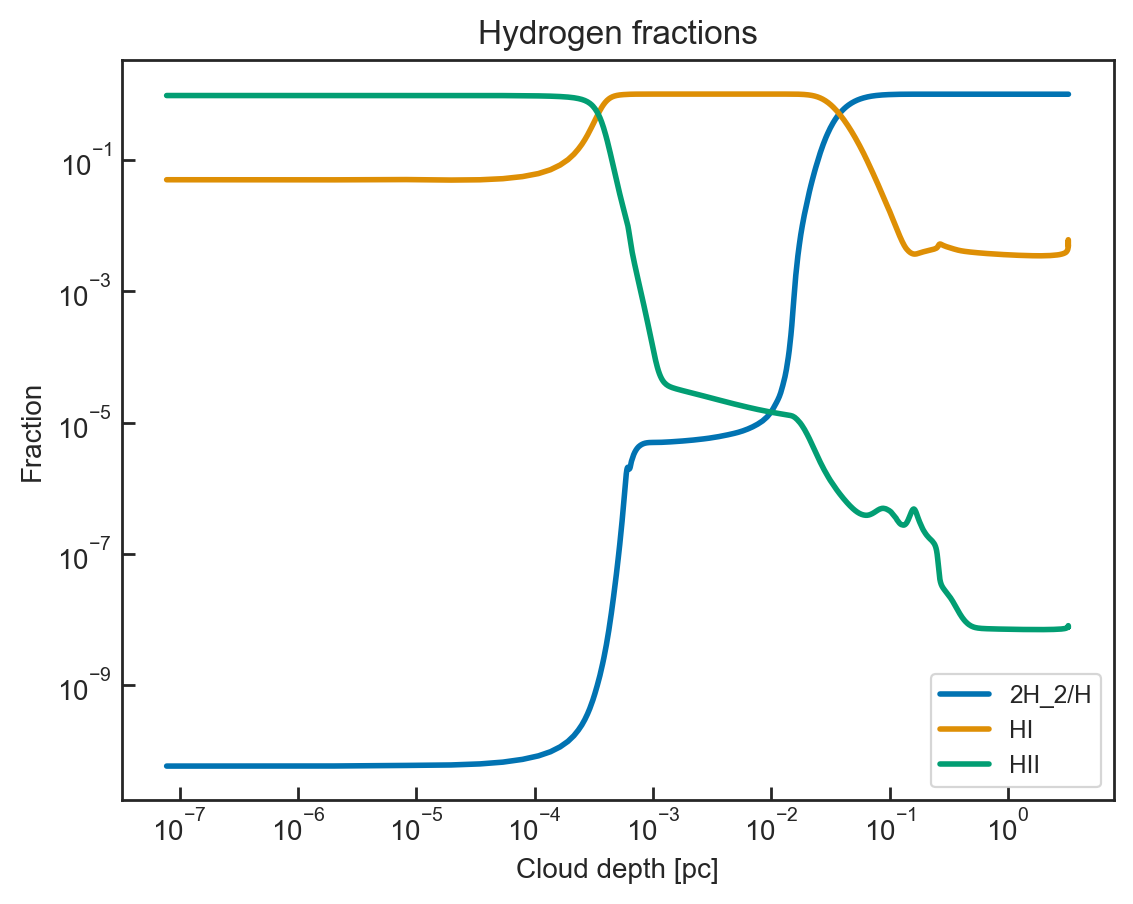

In [262]:
x = ovr['#depth'] / pc
ys = ['2H_2/H', 'HI', 'HII']

fig, ax = plt.subplots(1, 1)
ax.set_title('Hydrogen fractions')

for y in ys:
    ax.loglog(x, ovr[y], label=y, lw=2)

ax.legend()
ax.set_xlabel('Cloud depth [pc]')
ax.set_ylabel('Fraction');
#ax.set_yscale('linear');

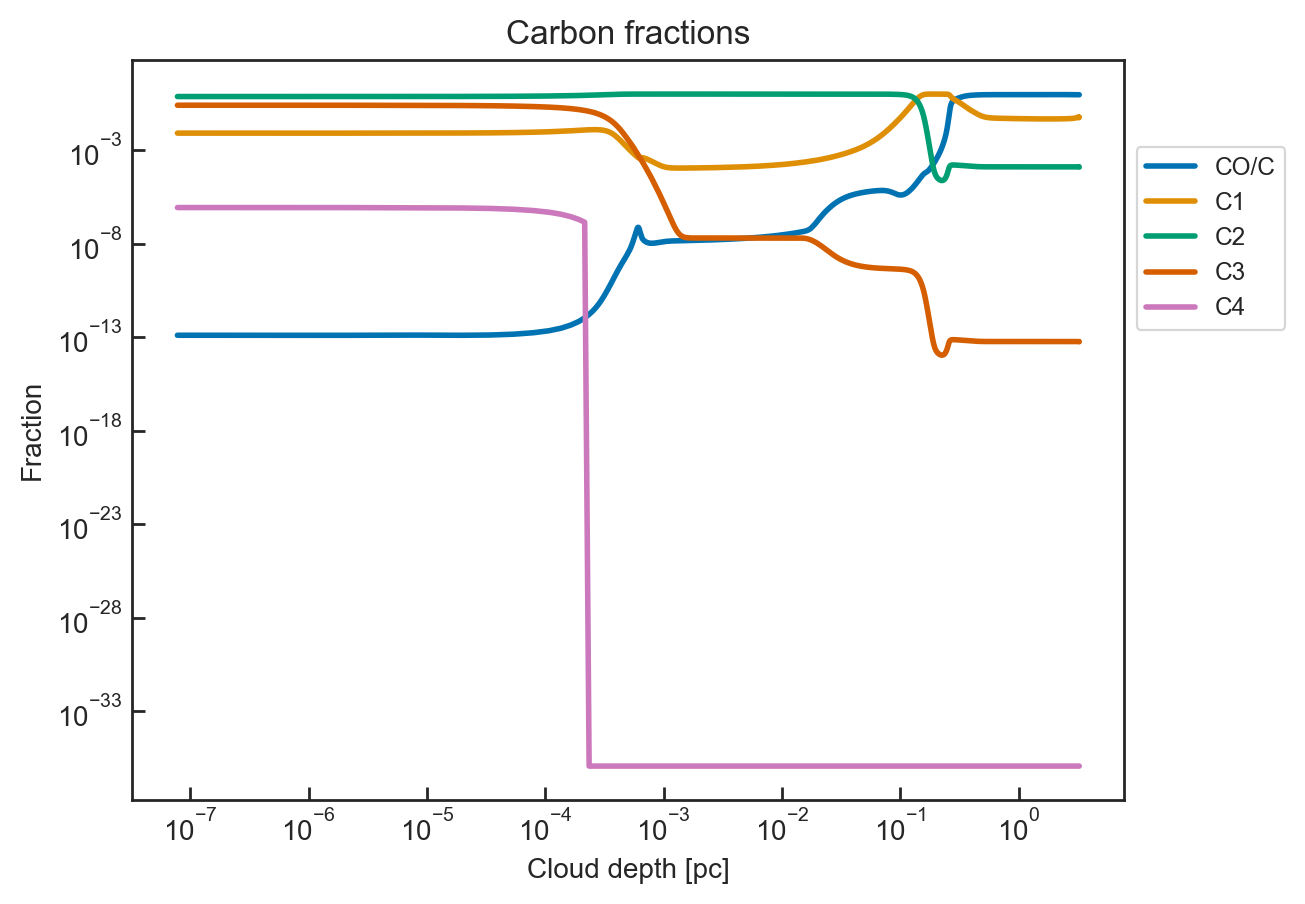

In [267]:
x = ovr['#depth'] / pc
ys = ['CO/C', 'C1', 'C2', 'C3', 'C4']

fig, ax = plt.subplots(1, 1)
ax.set_title('Carbon fractions')

for y in ys:
    ax.loglog(x, ovr[y], label=y, lw=2)

ax.set_xlabel('Cloud depth [pc]')
ax.set_ylabel('Fraction');
#ax.set_yscale('linear')
ax.legend(bbox_to_anchor=(1, .9));

## EMIS file

In [314]:
# import files and print column names
emis = pd.read_csv(prefix + '.emis', sep='\t')
emis.columns

Index(['#depth', 'CO 2600.05m ', 'CO 1300.05m ', 'CO 866.727m ',
       'CO 650.074m ', 'CO 520.089m ', 'CO 433.438m ', 'CO 371.549m ',
       'CO 325.137m ', 'CO 289.041m ', 'CO 260.169m ', 'CO 236.549m ',
       'CO 216.868m ', 'CO 200.218m ', '^13CO 2719.67m ', '^13CO 1359.86m ',
       '^13CO 906.599m ', 'HCN 3381.52m ', 'HCN 1690.78m ', 'HCN 1127.22m ',
       'HCN 845.428m ', 'HCN 676.373m ', 'HCN 563.665m ', 'HCN 483.168m ',
       'HCN 422.796m ', 'HCO+ 3360.43m ', 'HCO+ 1680.21m ', 'HCO+ 1120.18m ',
       'HCO+ 840.150m ', 'HCO+ 672.144m ', 'HCO+ 560.140m ', 'HCO+ 480.147m ',
       'HCO+ 420.151m ', 'HNC 3305.75m ', 'HNC 1652.90m ', 'HNC 1101.95m ',
       'HNC 826.492m ', 'HNC 661.221m ', 'HNC 551.041m ', 'HNC 472.351m ',
       'HNC 413.333m ', 'C  1 609.590m ', 'C  1 370.269m ', 'C  2 157.636m ',
       'O  1 63.1679m ', 'O  1 145.495m ', 'O  3 88.3323m ', 'N  2 205.244m ',
       'N  2 121.767m ', 'H  1 6562.81A ', 'H  1 4861.33A ', 'H  1 1.87510m ',
       'O  3 5006.84

In [269]:
emislabs = ['cm', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'CO9', 'CO10', 'CO11', 'CO12', 'CO13', 
            '13CO1', '13CO2', '13CO3', 'HCN1', 'HCN2', 'HCN3', 'HCN4', 'HCN5', 'HCN6', 'HCN7', 'HCN8', 
            'HCO1', 'HCO2', 'HCO3', 'HCO4', 'HCO5', 'HCO6', 'HCO7', 'HCO8', 'HNC1', 'HNC2', 'HNC3', 'HNC4', 
            'HNC5', 'HNC6', 'HNC7', 'HNC8', 'CI1', 'CI2', 'CII158', 'OI63', 'OI145', 'OIII88', 'NII205', 
            'NII122', 'Halpha', 'Hbeta', 'Paalpha', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300']
emisdict = dict(zip(emislabs, emis.columns))

**IMPORTANT**: if you want to include H2 lines you need to include the command `database H2` in the input file

### Line cumulative emission

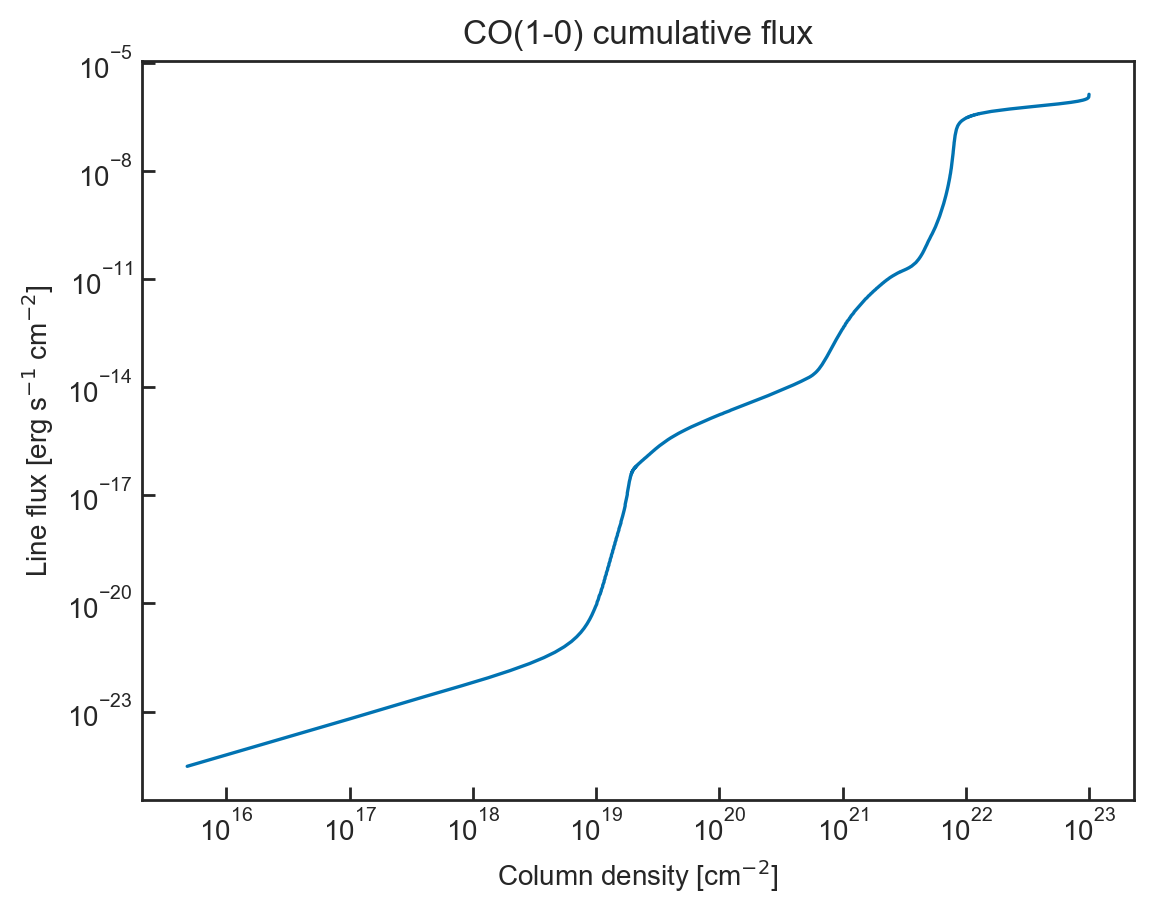

In [270]:
x = pdr['H colden']
y = emis[emisdict['CO1']]

fig, ax = plt.subplots(1, 1)
ax.set_title('CO(1-0) cumulative flux')
ax.loglog(x, y)
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### Line incremental emission

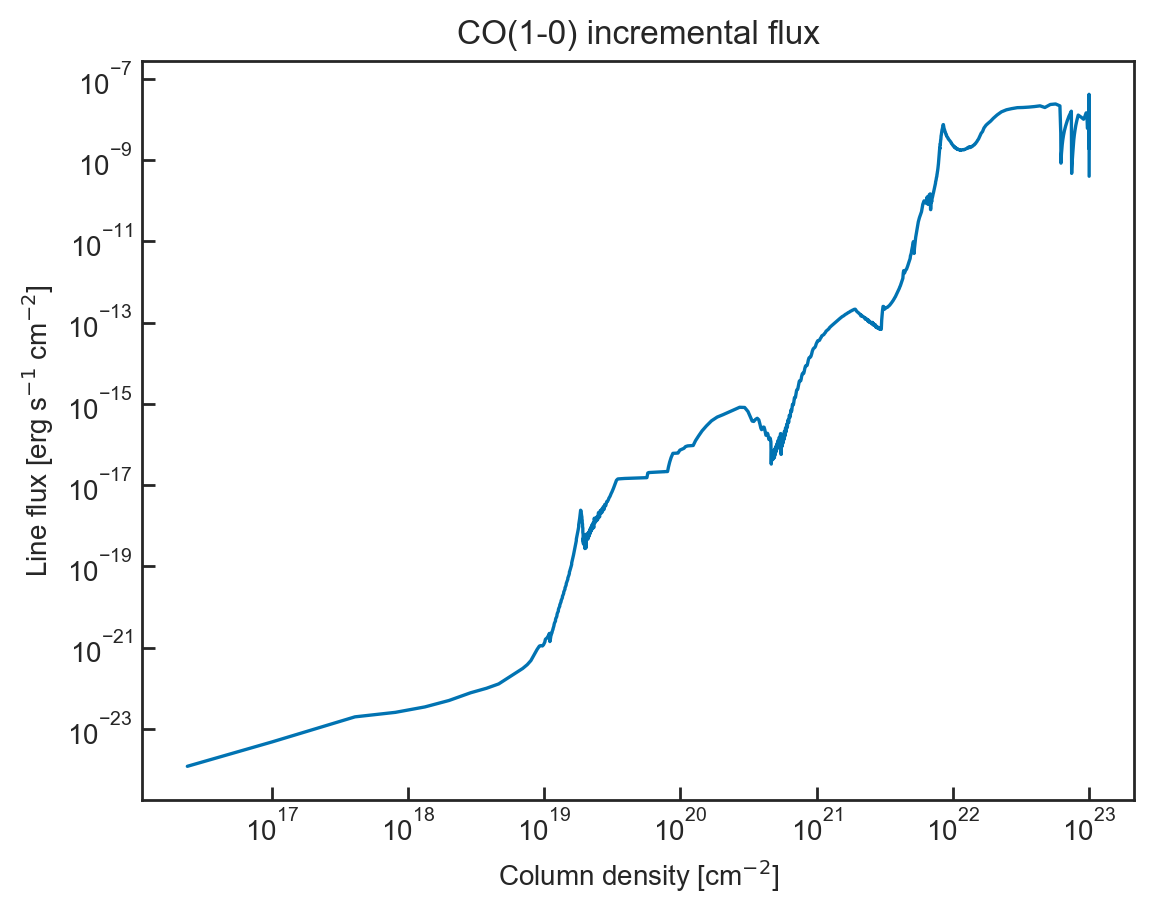

In [271]:
x = pdr['H colden']
y = emis[emisdict['CO1']]

fig, ax = plt.subplots(1, 1)
ax.set_title('CO(1-0) incremental flux')
ax.loglog(x[1:], np.diff(y))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### CO lines

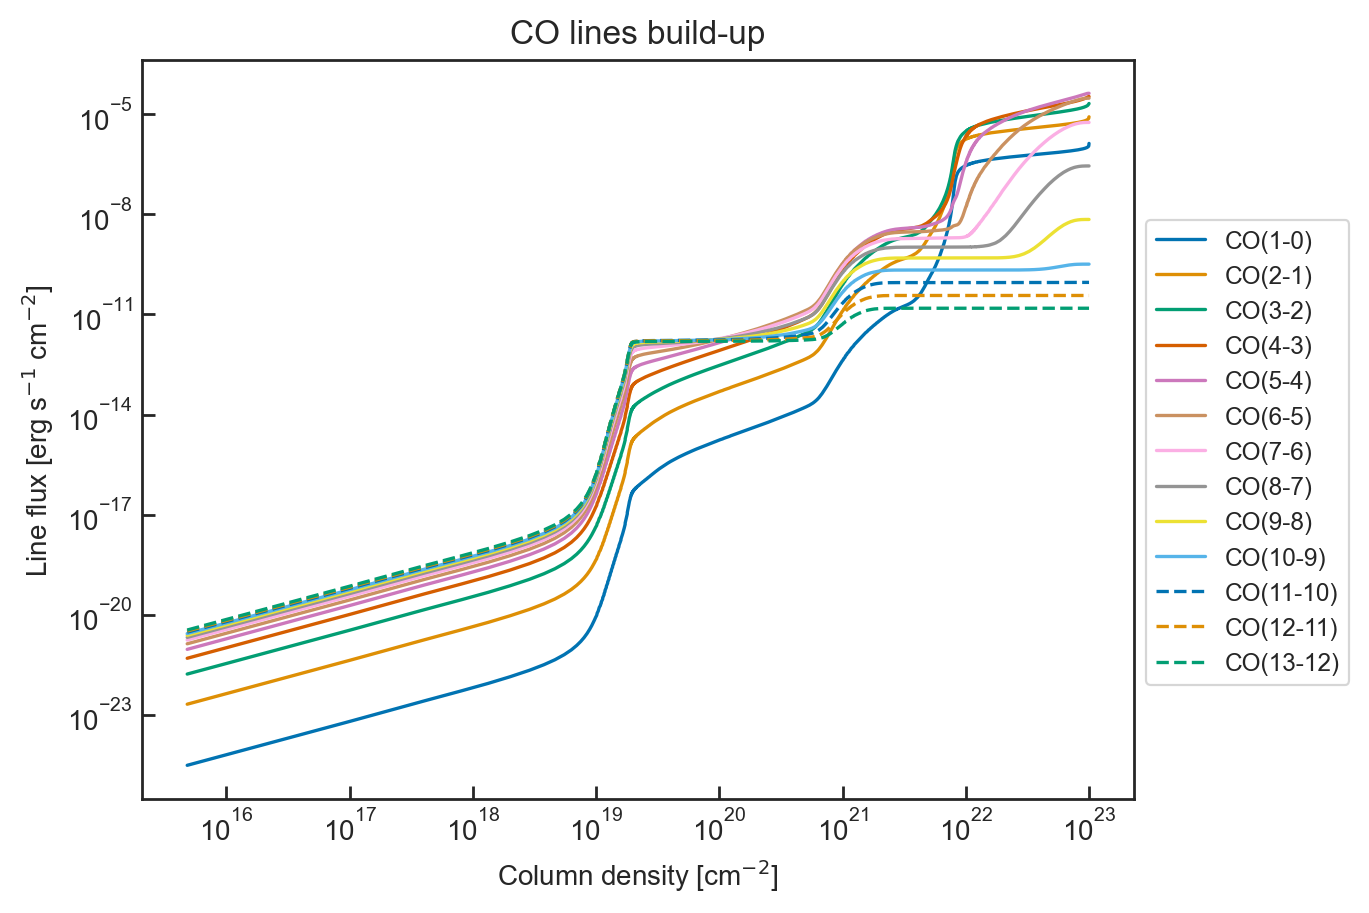

In [272]:
x = pdr['H colden']
lss = ['-']*10 + ['--']*3

fig, ax = plt.subplots(1, 1)
ax.set_title('CO lines build-up')

for l in range(1, 14):
    y = emis[emisdict['CO%1d' % l]]
    ylab = 'CO(%1d-%1d)' % (l, l-1)
    ax.loglog(x, y, label=ylab, ls=lss[l-1])

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### CO SLED

SLED = spectral line energy distribution

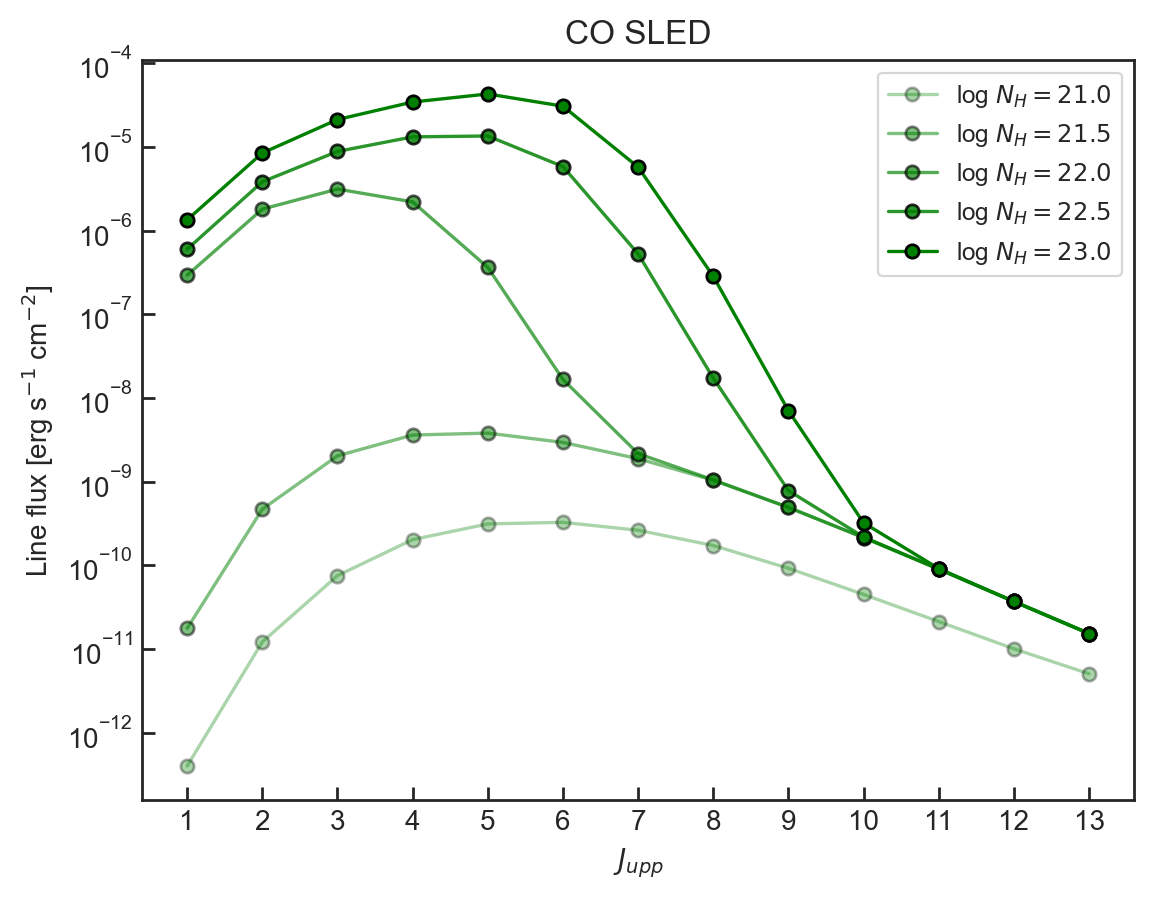

In [273]:
x = np.arange(1, 14)

fig, ax = plt.subplots(1, 1)
ax.set_title('CO SLED')

for logNH in np.arange(21, 23.1, .5):
    i = np.abs(np.log10(pdr['H colden']) - logNH).argmin()
    y = [emis[emisdict['CO%1d' % l]].iloc[i] for l in range(1, 14)]
    ax.plot(x, y, c='g', marker='o', mec='k', label=r'log $N_H = %.1f$' % logNH, alpha=(logNH - 20)/ (23-20))

ax.set_yscale('log')
ax.legend()
ax.set_xticks(x)
ax.set_xlabel('$J_{upp}$')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### Tracing carbon emission

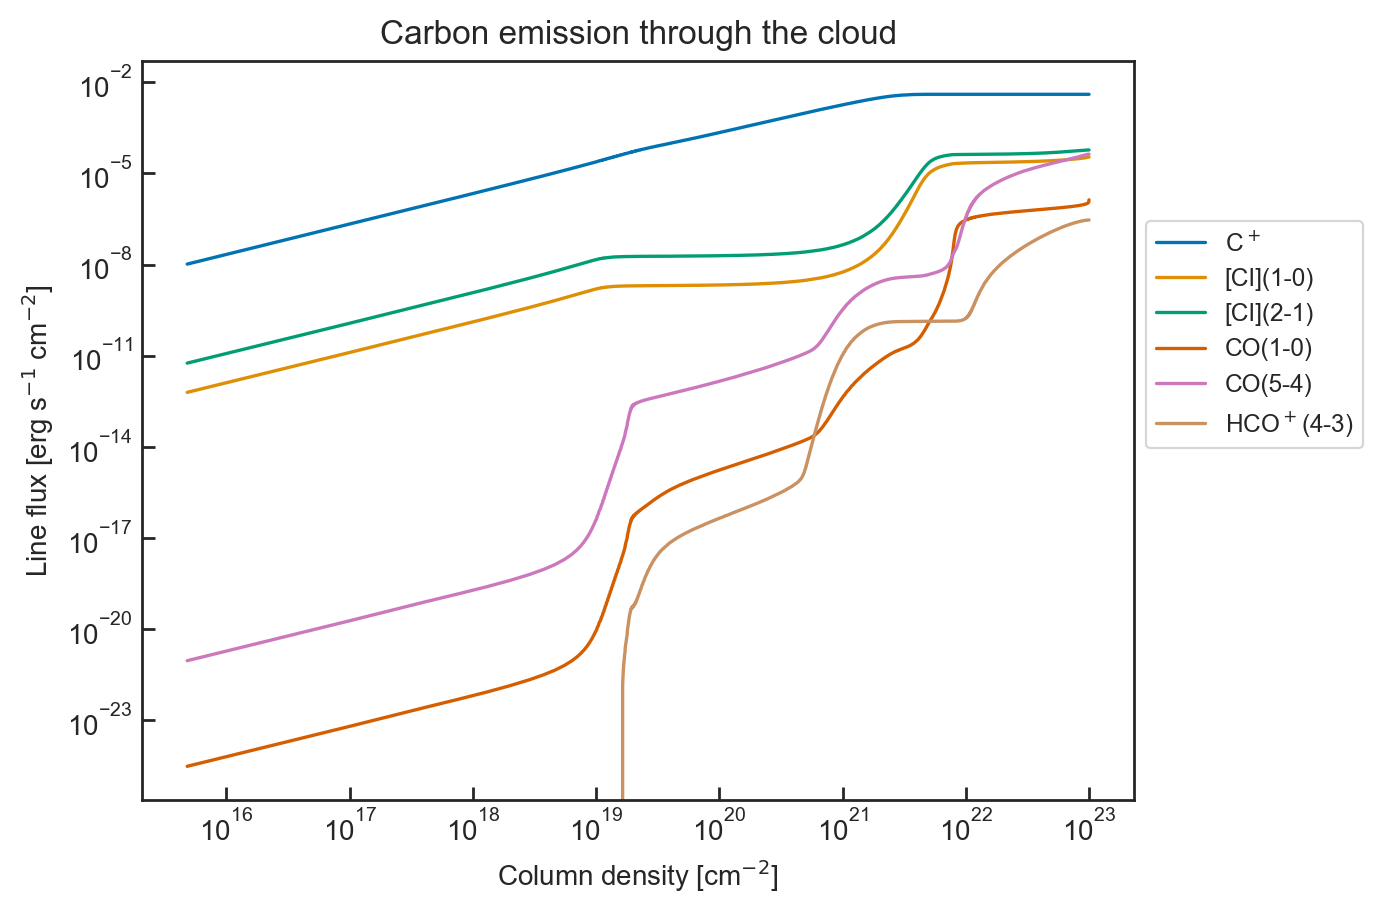

In [274]:
x = pdr['H colden']
lines = ['CII158', 'CI1', 'CI2', 'CO1', 'CO5', 'HCO4']
labs = ['C$^+$', '[CI](1-0)', '[CI](2-1)', 'CO(1-0)', 'CO(5-4)', 'HCO$^+$(4-3)']

fig, ax = plt.subplots(1, 1)
ax.set_title('Carbon emission through the cloud')

for l, lab in zip(lines, labs):
    y = emis[emisdict[l]]
    ax.loglog(x, y, label=lab)

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### Ionized gas: typical optical lines

In [275]:
emisdict.keys()

dict_keys(['cm', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'CO9', 'CO10', 'CO11', 'CO12', 'CO13', '13CO1', '13CO2', '13CO3', 'HCN1', 'HCN2', 'HCN3', 'HCN4', 'HCN5', 'HCN6', 'HCN7', 'HCN8', 'HCO1', 'HCO2', 'HCO3', 'HCO4', 'HCO5', 'HCO6', 'HCO7', 'HCO8', 'HNC1', 'HNC2', 'HNC3', 'HNC4', 'HNC5', 'HNC6', 'HNC7', 'HNC8', 'CI1', 'CI2', 'CII158', 'OI63', 'OI145', 'OIII88', 'NII205', 'NII122', 'Halpha', 'Hbeta', 'Paalpha', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300'])

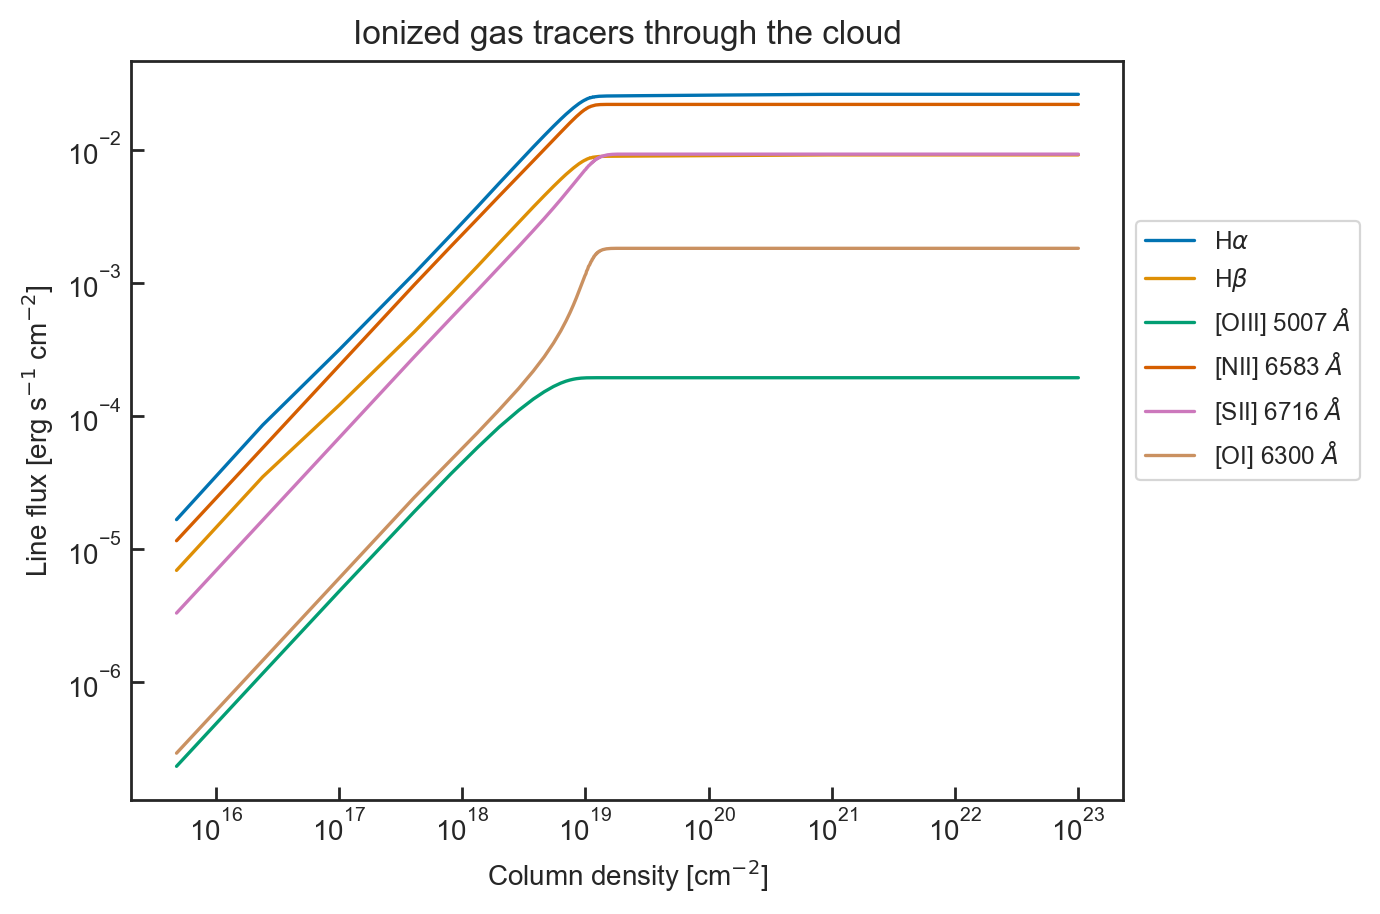

In [276]:
x = pdr['H colden']
lines = ['Halpha', 'Hbeta', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300']
labs = [r'H$\alpha$', r'H$\beta$', '[OIII] 5007 $\AA$', '[NII] 6583 $\AA$', '[SII] 6716 $\AA$', '[OI] 6300 $\AA$']

fig, ax = plt.subplots(1, 1)
ax.set_title('Ionized gas tracers through the cloud')

for l, lab in zip(lines, labs):
    y = emis[emisdict[l]]
    ax.loglog(x, y, label=lab)

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### BPT line ratios

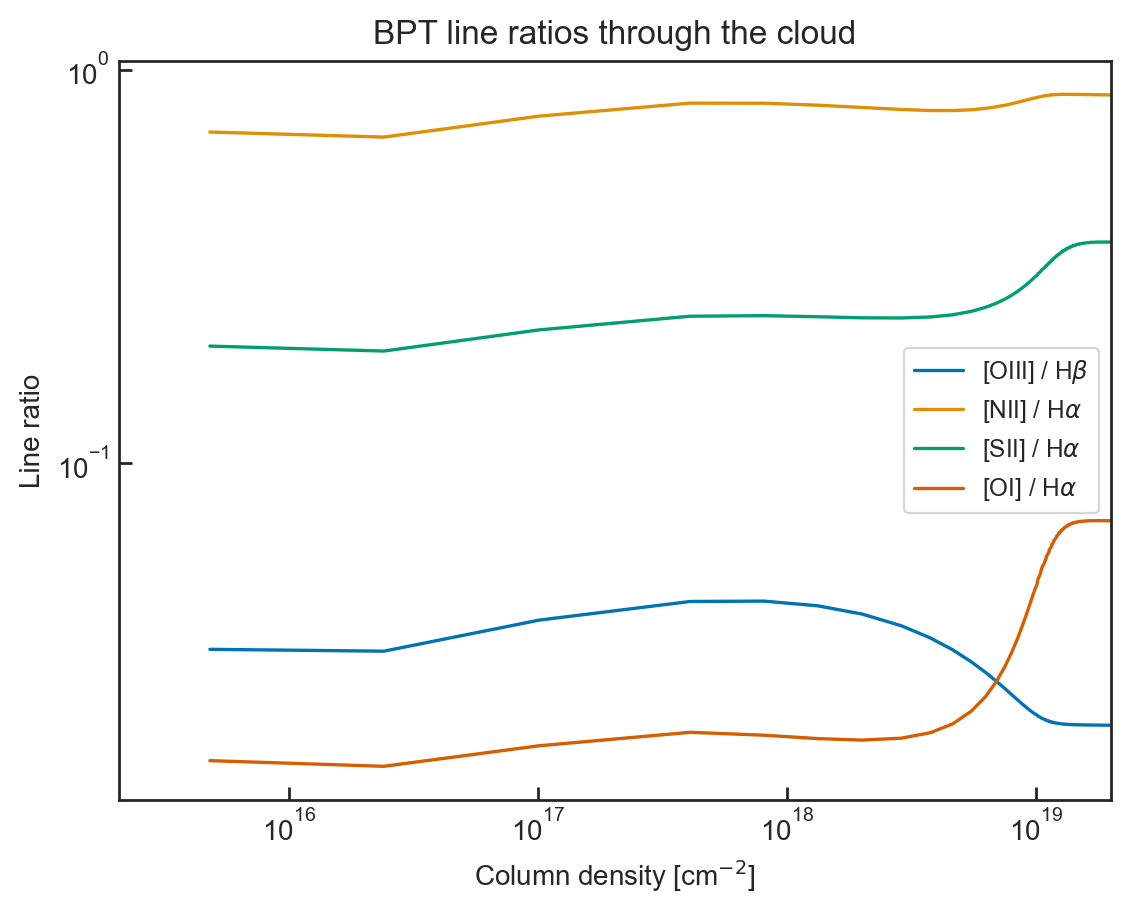

In [278]:
x = pdr['H colden']
r1 = emis[emisdict['[OIII]5007']] / emis[emisdict['Hbeta']]
r2 = emis[emisdict['[NII]6583']] / emis[emisdict['Halpha']]
r3 = emis[emisdict['[SII]6716']] / emis[emisdict['Halpha']]
r4 = emis[emisdict['[OI]6300']] / emis[emisdict['Halpha']]
labs = [r'[OIII] / H$\beta$', r'[NII] / H$\alpha$', r'[SII] / H$\alpha$', r'[OI] / H$\alpha$']

fig, ax = plt.subplots(1, 1)
ax.set_title('BPT line ratios through the cloud')

for r, lab in zip([r1, r2, r3, r4], labs):
    ax.loglog(x, r, label=lab)

ax.legend()
ax.set_xlim(right=2e19)
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line ratio');

In [315]:
def kewley01(x):
	if x < 0.47:
		return 0.61 / (x - 0.47) + 1.19
	else:
		return -9 # a high negative number out of the plot

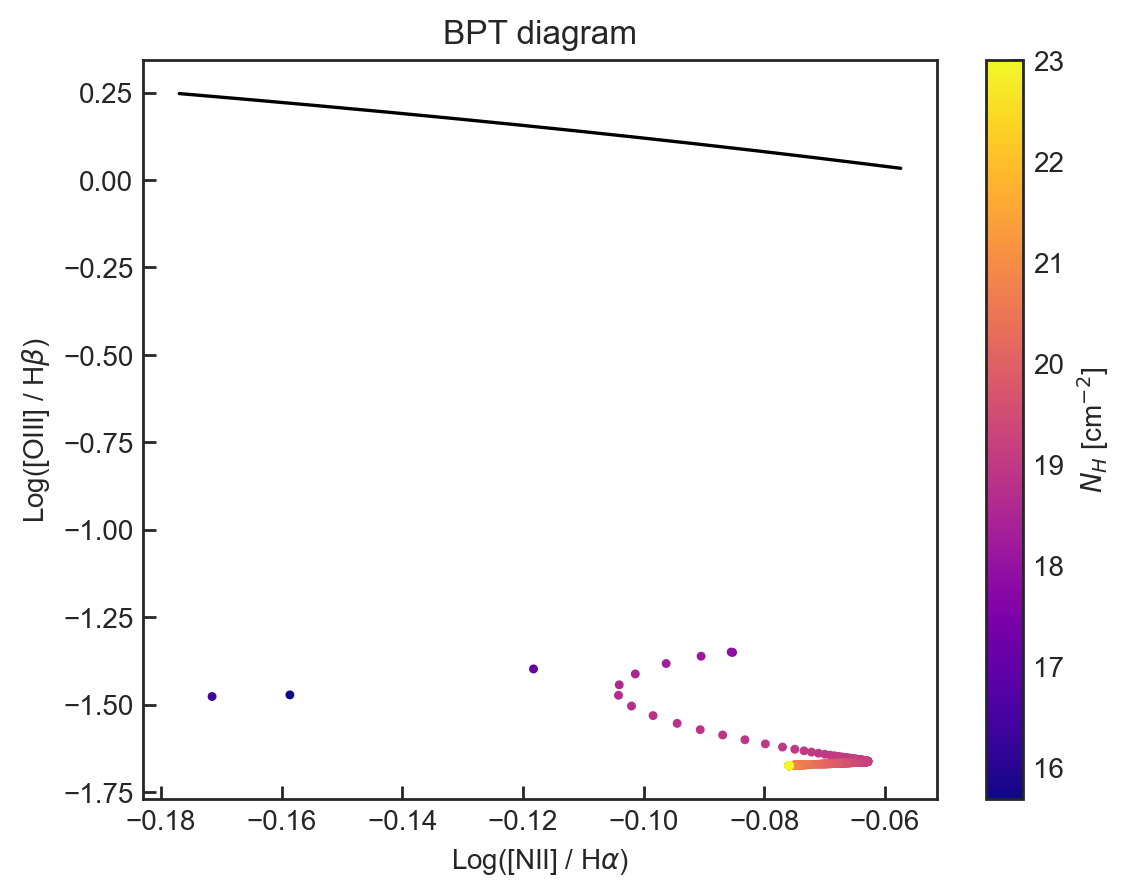

In [316]:
r1 = np.log10(emis[emisdict['[OIII]5007']] / emis[emisdict['Hbeta']])
r2 = np.log10(emis[emisdict['[NII]6583']] / emis[emisdict['Halpha']])
r3 = np.log10(emis[emisdict['[SII]6716']] / emis[emisdict['Halpha']])
r4 = np.log10(emis[emisdict['[OI]6300']] / emis[emisdict['Halpha']])
labs = [r'Log([OIII] / H$\beta$)', r'Log([NII] / H$\alpha$)', r'Log([SII] / H$\alpha$)', r'Log([OI] / H$\alpha$)']

fig, ax = plt.subplots(1, 1)
ax.set_title('BPT diagram')
sp = ax.scatter(r2, r1, marker='.', c=np.log10(pdr['H colden']), cmap='plasma')
cbar = fig.colorbar(sp, ax=ax, label='$N_H$ [cm$^{-2}$]')
ax.set_xlabel(labs[1])
ax.set_ylabel(labs[0]);

# theoretical line (Kewley+2001)
xrange = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
ax.plot(xrange, [kewley01(x) for x in xrange], c='k');

# XDR simulation

In [296]:
#prefix = '../pdr/pdr5_h400_g000'
prefix = '../xdr/agn5_h400_x000'

## Continuum file

In [297]:
# import files and print column names
cont = pd.read_csv(prefix + '.cont', sep='\t')
print(cont.columns.to_numpy())

['#Cont  nu' 'incident' 'trans' 'DiffOut' 'net trans' 'reflc' 'total'
 'reflin' 'outlin' 'lineID' 'cont' 'nLine']


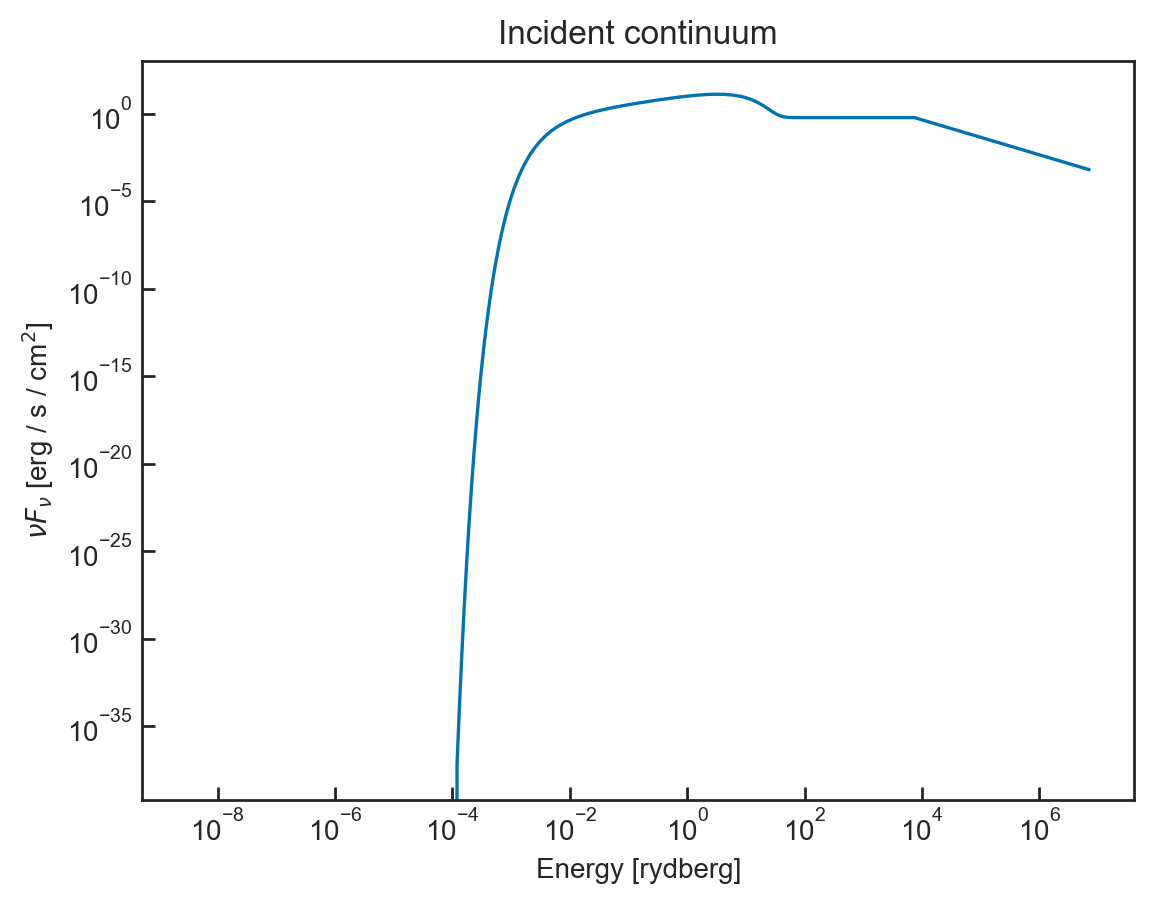

In [282]:
x = cont['#Cont  nu']
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Energy [rydberg]')
ax.set_ylabel(r'$\nu F_{\nu}$ [erg / s / cm$^2$]');
#ax.set_ylim(bottom=1e-7)
#ax.set_xlim(left=1e-4);

#### Change to energy in keV

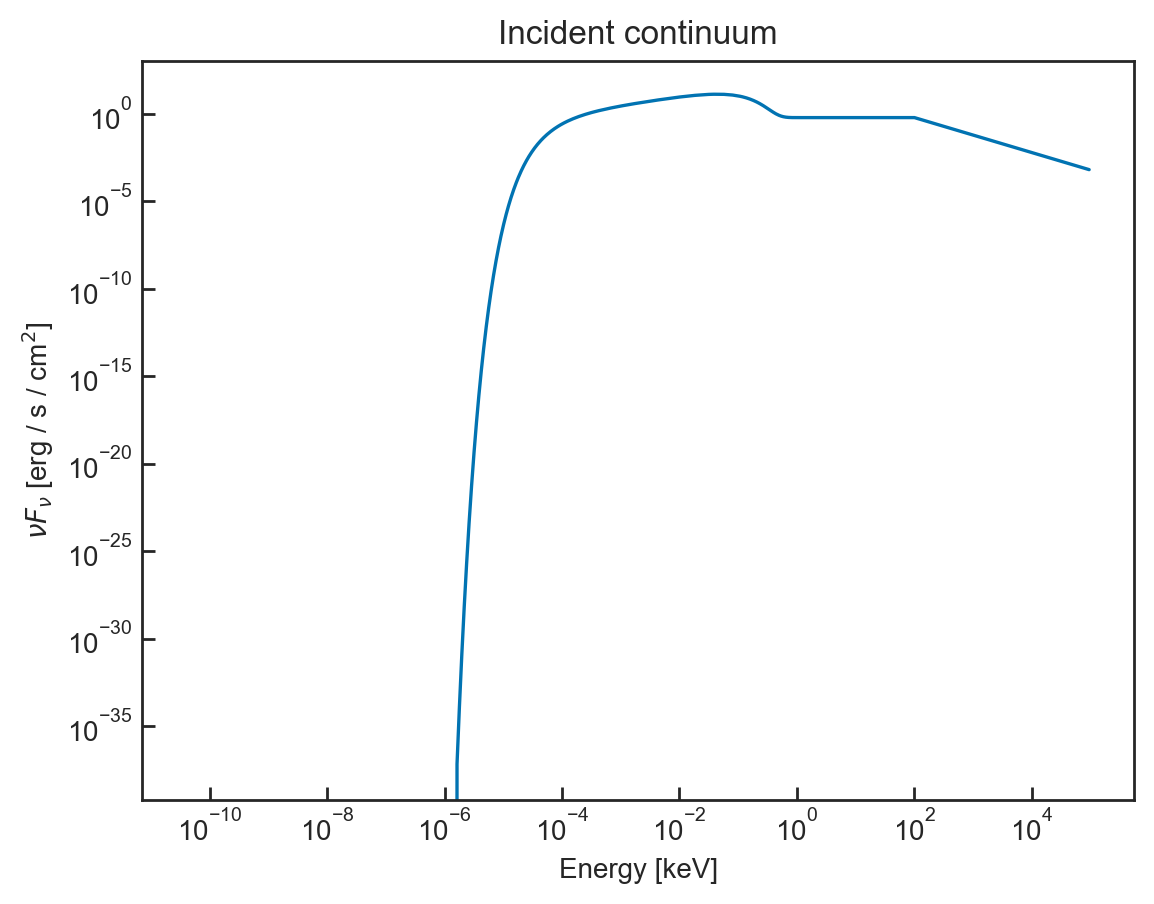

In [283]:
x = cont['#Cont  nu'] * ry_ev / 1e3
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'$\nu F_{\nu}$ [erg / s / cm$^2$]');
#ax.set_ylim(bottom=1e-7)
#ax.set_xlim(left=1e-6);
#ax.axvspan(2, 10, fc='gray', ls='none', alpha=.1);

#### Check the integrated flux

In [284]:
energy_kev = cont['#Cont  nu'] * ry_ev / 1e3
kev2_10 = (energy_kev >= 2.) & (energy_kev <= 10.)
x = energy_kev[kev2_10]
y = cont['incident'][kev2_10] / x
flux_integral = simpson(y, x=x)
print('2-10 keV flux is %.2f erg/s/cm^2' % flux_integral)

2-10 keV flux is 1.00 erg/s/cm^2


#### Change to wavelength

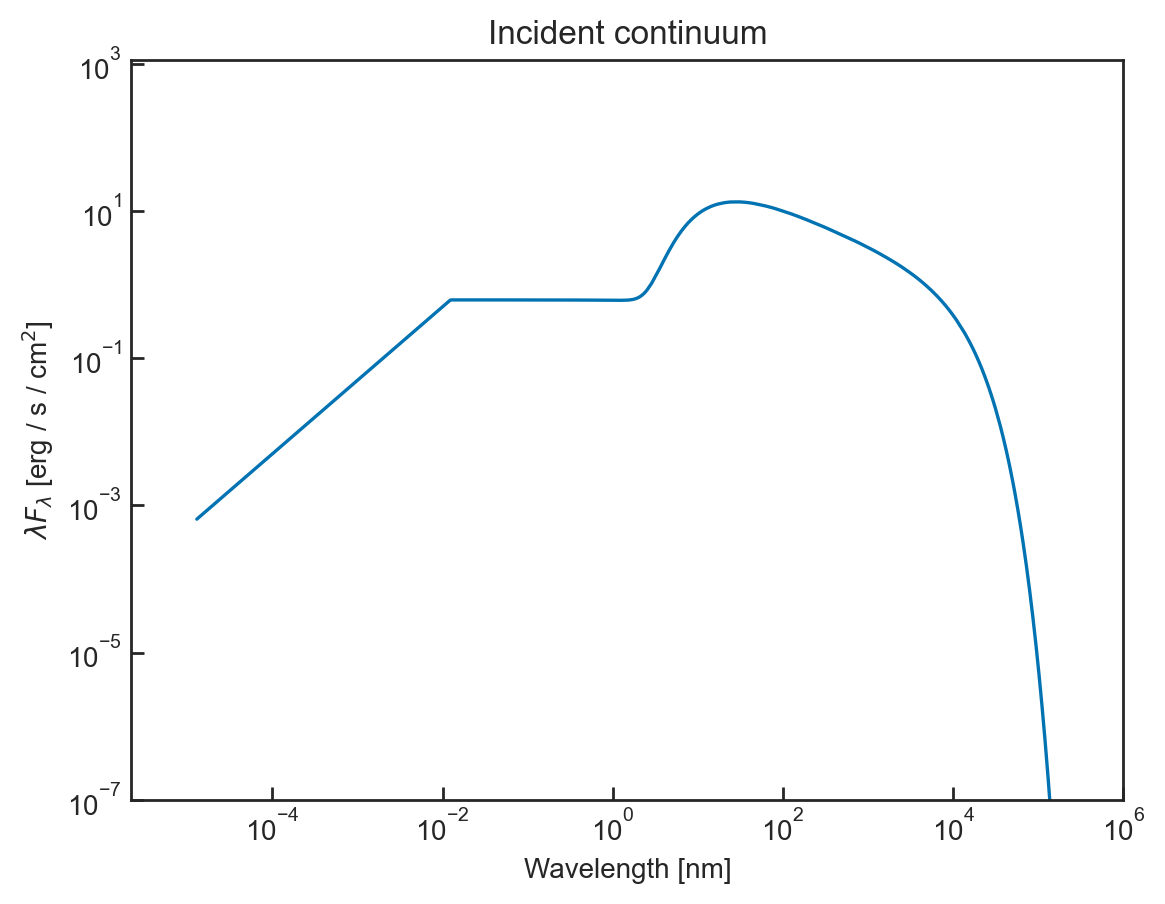

In [285]:
x = ry_nm / cont['#Cont  nu']
y = cont['incident']

fig, ax = plt.subplots(1, 1)
ax.set_title('Incident continuum')
ax.loglog(x, y)
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel(r'$\lambda F_{\lambda}$ [erg / s / cm$^2$]')
ax.set_ylim(bottom=1e-7)
ax.set_xlim(right=1e6);

### Continuum radiation from the cloud

Columns of interest:
- `trans`: transmitted incident continuum and does not include diffuse emission from the cloud
- `DiffOut`: outward portion of the emitted continuum and line emission, does not include the attenuated or reflected emission
- `net trans`: net transmitted continuum = `trans` + `DiffOut`
- `reflc`: reflected continuum
- `total`: `net trans` + `reflc`
- `reflin`: sum of all reflected line emission
- `outlin`: sum of all outward line emission

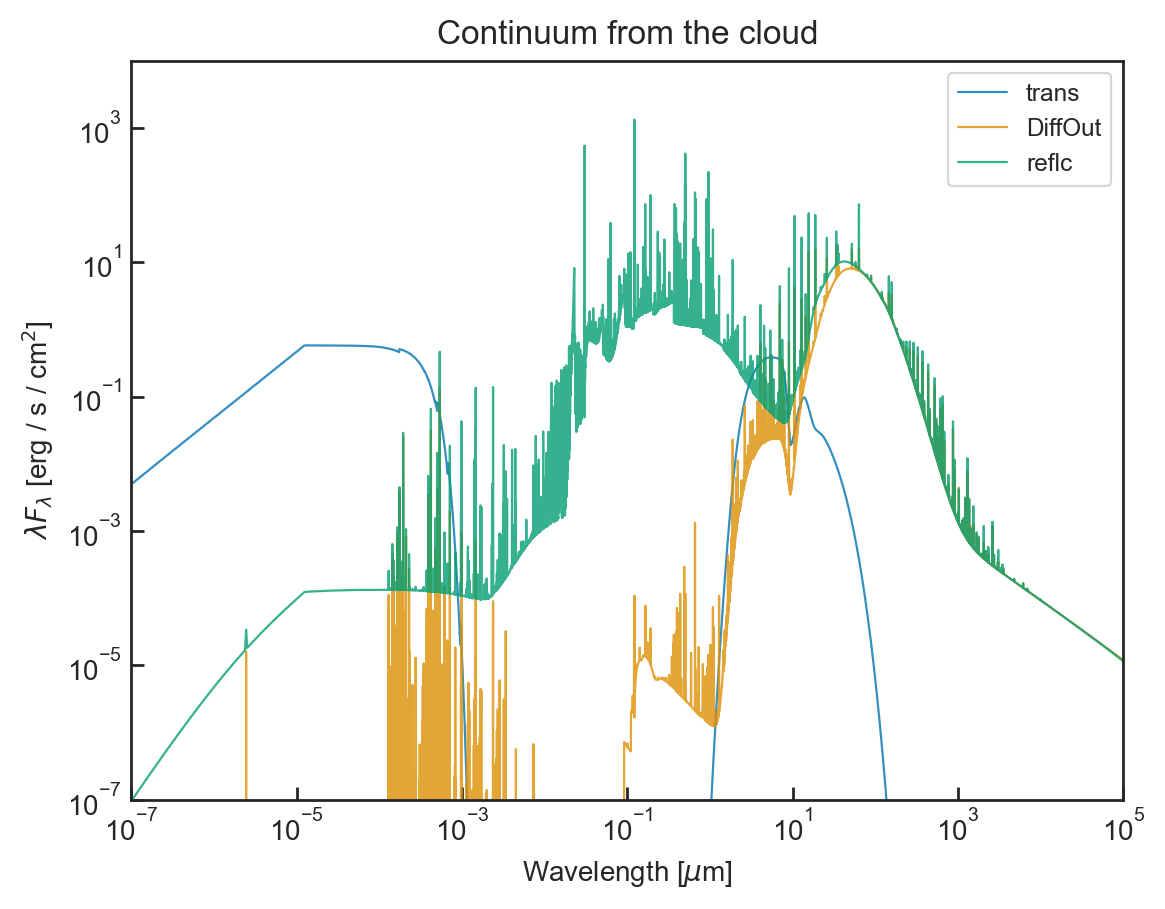

In [286]:
x = ry_nm / cont['#Cont  nu'] / 1e3
ys = ['trans', 'DiffOut', 'reflc']

fig, ax = plt.subplots(1, 1)
ax.set_title('Continuum from the cloud')

for y in ys:
    ax.loglog(x, cont[y], label=y, lw=.8, alpha=.8)

ax.legend()
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$\lambda F_{\lambda}$ [erg / s / cm$^2$]');
ax.set_ylim([1e-7, 1e4])
ax.set_xlim([1e-7, 1e5]);
#ax.loglog(x, cont['incident'], label='incident', c='k', lw=.8, ls='--');

## OVR and PDR files

**OVR** columns:
- `#depth`: cloud depth [cm]
- `Te`: temperature [K]
- `Htot`: local heating [erg / s / cm$^3$]
- `hden`: total hydrogen density [cm$^{-3}$]
- `eden`: electron density [cm$^{-3}$]
- `2H_2/H`: fraction of molecular hydrogen
- `HI`: fraction of neutral hydrogen
- `HII`: fraction of ionized hydrogen
- `CO/C`: fraction of carbon in CO
- `C1`: fraction of neutral carbon
- `C2`: fraction of carbon ionized 1 time

**PDR** new columns:
- `H colden`: total hydrogen column density [cm$^{-2}$]
- `G0`: internal FUV field [$1.6 \times 10^{-3}$ erg / s / cm$^2$]

In [298]:
# import files and print column names
ovr = pd.read_csv(prefix + '.ovr', sep='\t')
pdr = pd.read_csv(prefix + '.pdr', sep='\t')

### Gas temperature

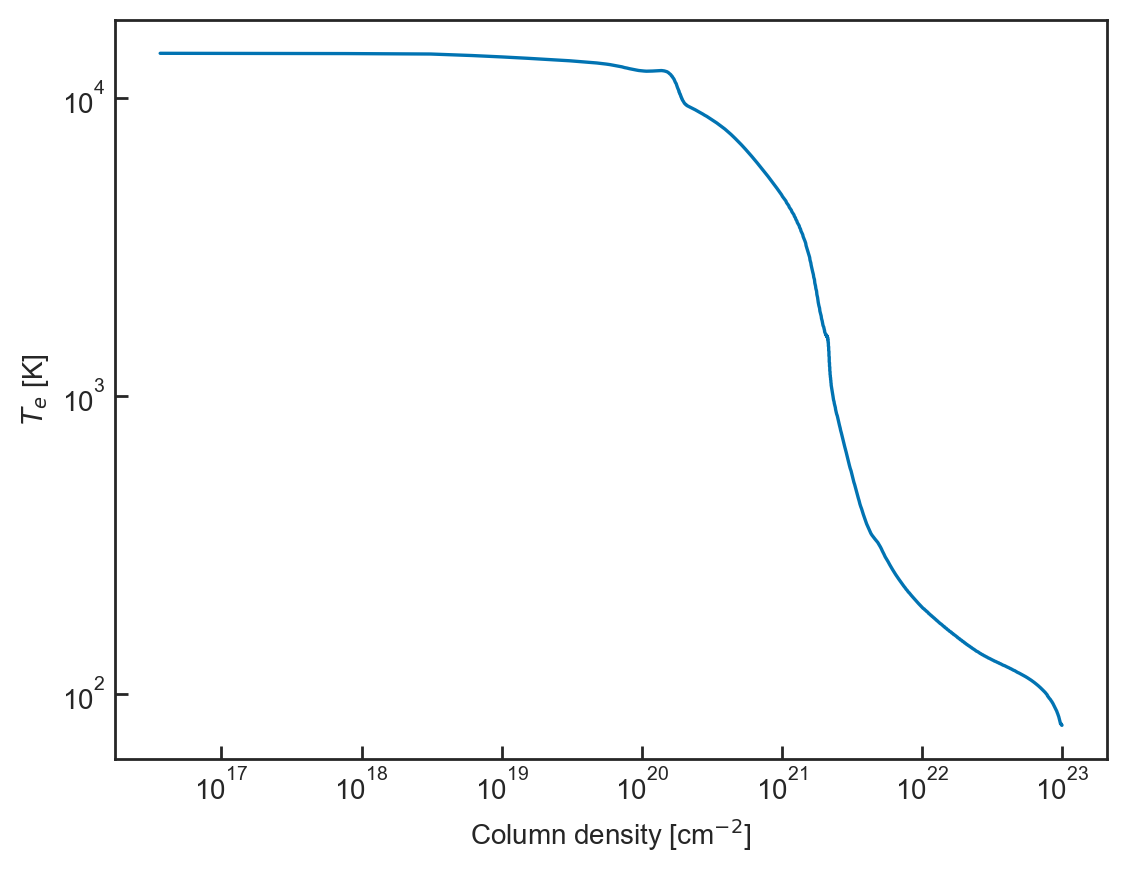

In [288]:
x = pdr['H colden']
y = ovr['Te']

fig, ax = plt.subplots(1, 1)
ax.loglog(x, y)
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('$T_e$ [K]');

### Ionization fractions

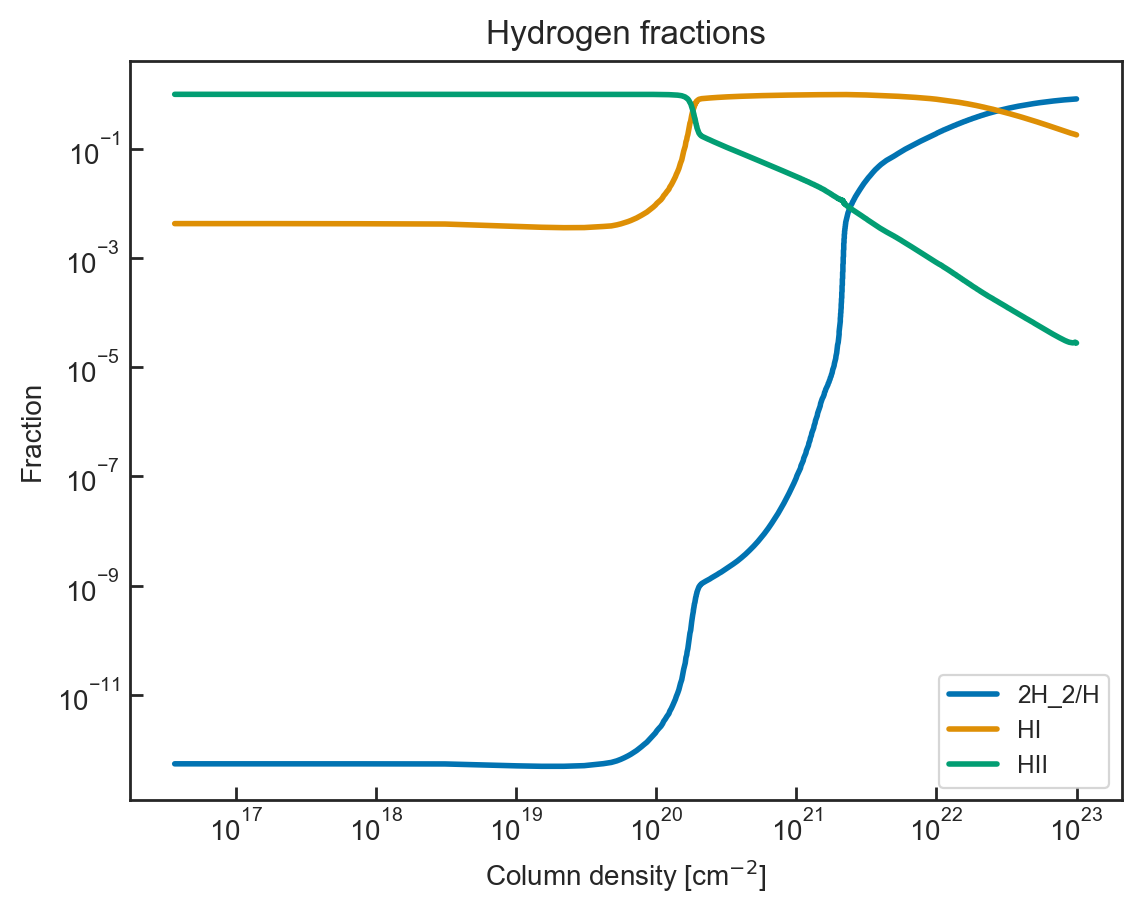

In [289]:
x = pdr['H colden']
ys = ['2H_2/H', 'HI', 'HII']

fig, ax = plt.subplots(1, 1)
ax.set_title('Hydrogen fractions')

for y in ys:
    ax.loglog(x, ovr[y], label=y, lw=2)

ax.legend()
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Fraction');

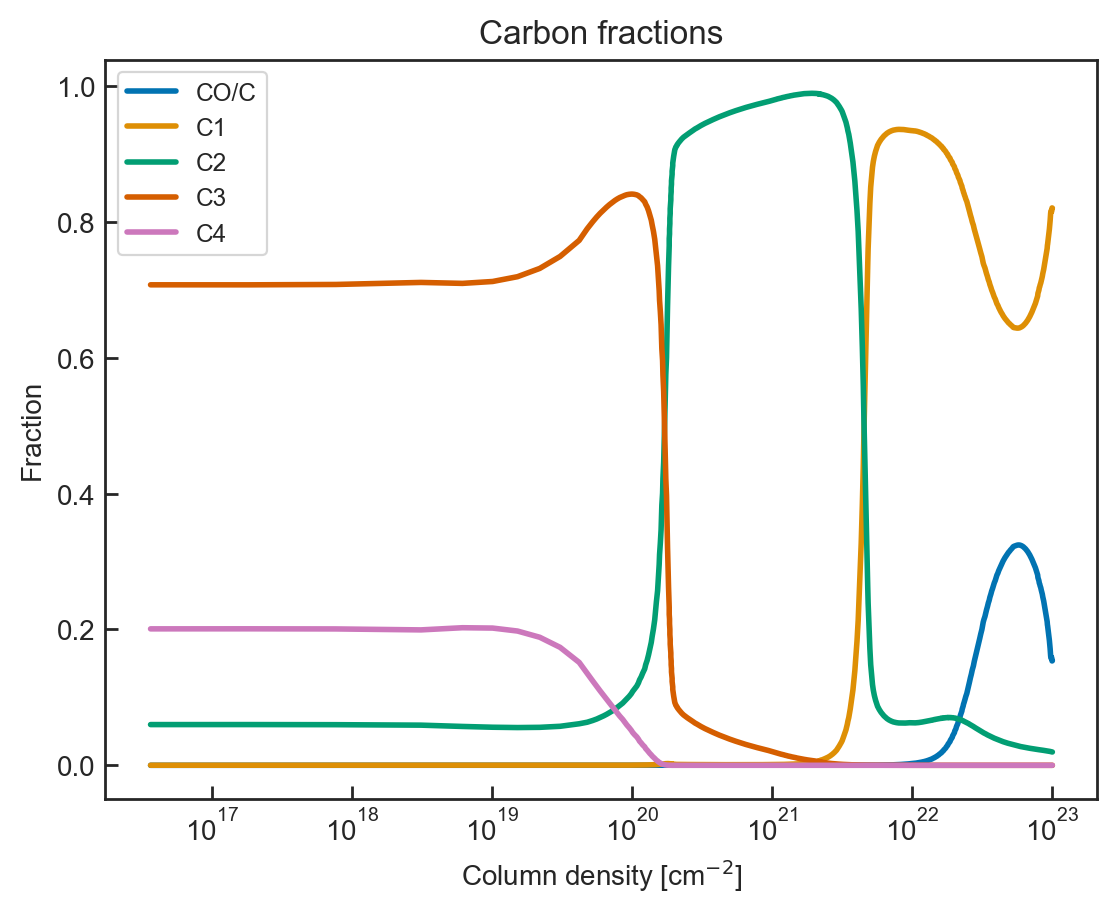

In [290]:
x = pdr['H colden']
ys = ['CO/C', 'C1', 'C2', 'C3', 'C4']

fig, ax = plt.subplots(1, 1)
ax.set_title('Carbon fractions')

for y in ys:
    ax.loglog(x, ovr[y], label=y, lw=2)

ax.legend()
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Fraction');
ax.set_yscale('linear');

## EMIS file

In [299]:
# import files and print column names
emis = pd.read_csv(prefix + '.emis', sep='\t')
emis.columns

Index(['#depth', 'CO 2600.05m ', 'CO 1300.05m ', 'CO 866.727m ',
       'CO 650.074m ', 'CO 520.089m ', 'CO 433.438m ', 'CO 371.549m ',
       'CO 325.137m ', 'CO 289.041m ', 'CO 260.169m ', 'CO 236.549m ',
       'CO 216.868m ', 'CO 200.218m ', '^13CO 2719.67m ', '^13CO 1359.86m ',
       '^13CO 906.599m ', 'HCN 3381.52m ', 'HCN 1690.78m ', 'HCN 1127.22m ',
       'HCN 845.428m ', 'HCN 676.373m ', 'HCN 563.665m ', 'HCN 483.168m ',
       'HCN 422.796m ', 'HCO+ 3360.43m ', 'HCO+ 1680.21m ', 'HCO+ 1120.18m ',
       'HCO+ 840.150m ', 'HCO+ 672.144m ', 'HCO+ 560.140m ', 'HCO+ 480.147m ',
       'HCO+ 420.151m ', 'HNC 3305.75m ', 'HNC 1652.90m ', 'HNC 1101.95m ',
       'HNC 826.492m ', 'HNC 661.221m ', 'HNC 551.041m ', 'HNC 472.351m ',
       'HNC 413.333m ', 'C  1 609.590m ', 'C  1 370.269m ', 'C  2 157.636m ',
       'O  1 63.1679m ', 'O  1 145.495m ', 'O  3 88.3323m ', 'N  2 205.244m ',
       'N  2 121.767m ', 'H  1 6562.81A ', 'H  1 4861.33A ', 'H  1 1.87510m ',
       'O  3 5006.84

In [294]:
emislabs = ['cm', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'CO9', 'CO10', 'CO11', 'CO12', 'CO13', 
            '13CO1', '13CO2', '13CO3', 'HCN1', 'HCN2', 'HCN3', 'HCN4', 'HCN5', 'HCN6', 'HCN7', 'HCN8', 
            'HCO1', 'HCO2', 'HCO3', 'HCO4', 'HCO5', 'HCO6', 'HCO7', 'HCO8', 'HNC1', 'HNC2', 'HNC3', 'HNC4', 
            'HNC5', 'HNC6', 'HNC7', 'HNC8', 'CI1', 'CI2', 'CII158', 'OI63', 'OI145', 'OIII88', 'NII205', 
            'NII122', 'Halpha', 'Hbeta', 'Paalpha', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300']
emisdict = dict(zip(emislabs, emis.columns))

**IMPORTANT**: if you want to include H2 lines you need to include the command `database H2` in the input file

### Line cumulative emission

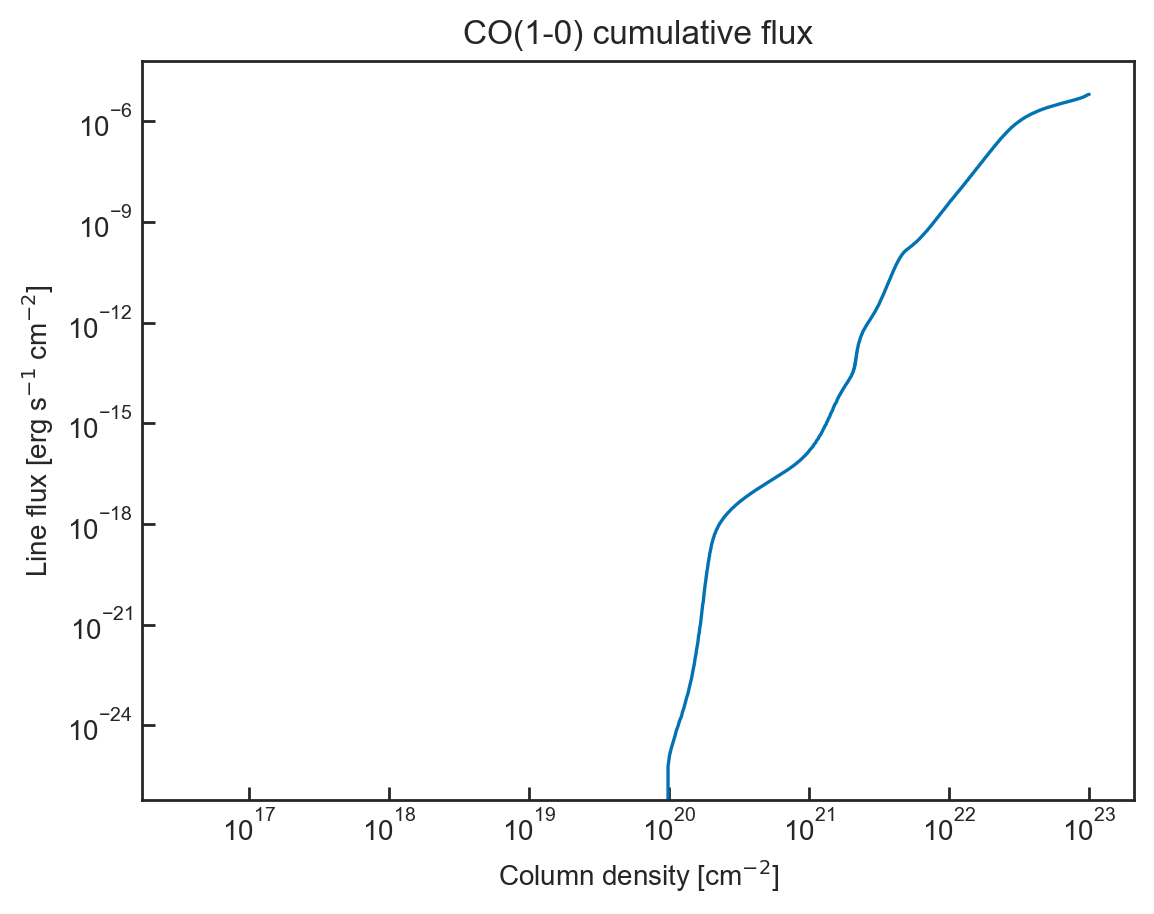

In [300]:
x = pdr['H colden']
y = emis[emisdict['CO1']]

fig, ax = plt.subplots(1, 1)
ax.set_title('CO(1-0) cumulative flux')
ax.loglog(x, y)
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### Line incremental emission

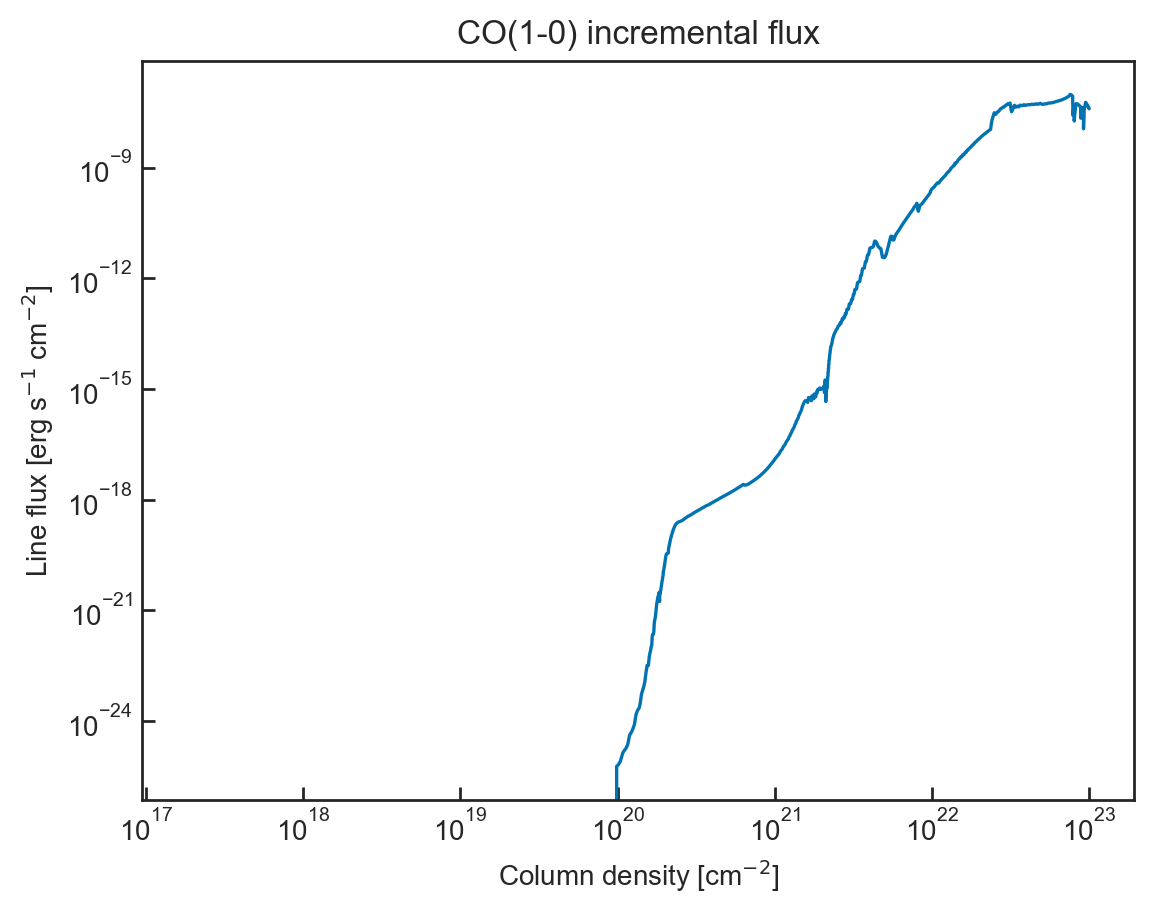

In [301]:
x = pdr['H colden']
y = emis[emisdict['CO1']]

fig, ax = plt.subplots(1, 1)
ax.set_title('CO(1-0) incremental flux')
ax.loglog(x[1:], np.diff(y))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### CO lines

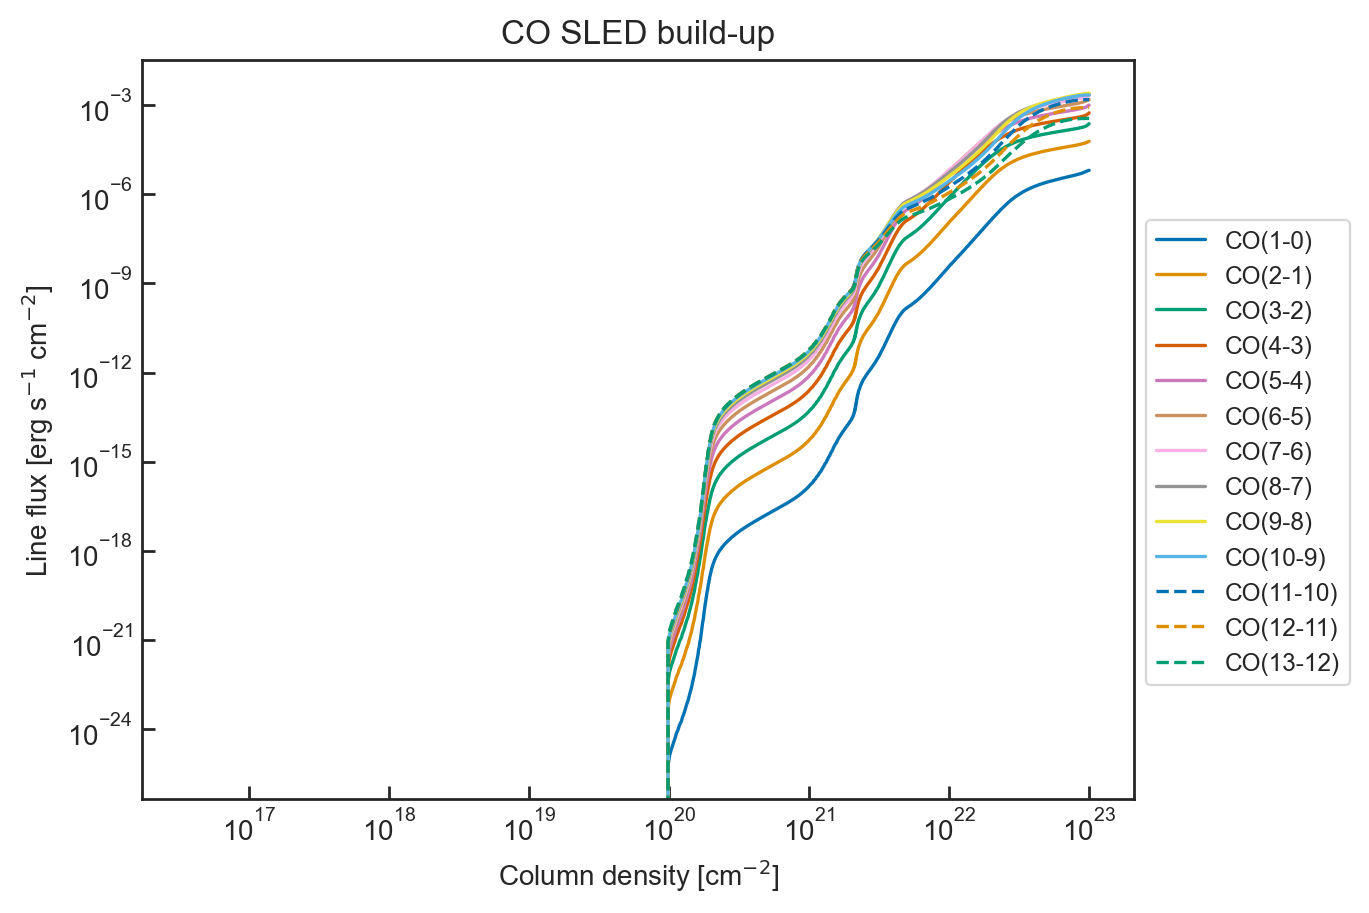

In [302]:
x = pdr['H colden']
lss = ['-']*10 + ['--']*3

fig, ax = plt.subplots(1, 1)
ax.set_title('CO SLED build-up')

for l in range(1, 14):
    y = emis[emisdict['CO%1d' % l]]
    ylab = 'CO(%1d-%1d)' % (l, l-1)
    ax.loglog(x, y, label=ylab, ls=lss[l-1])

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### CO SLED

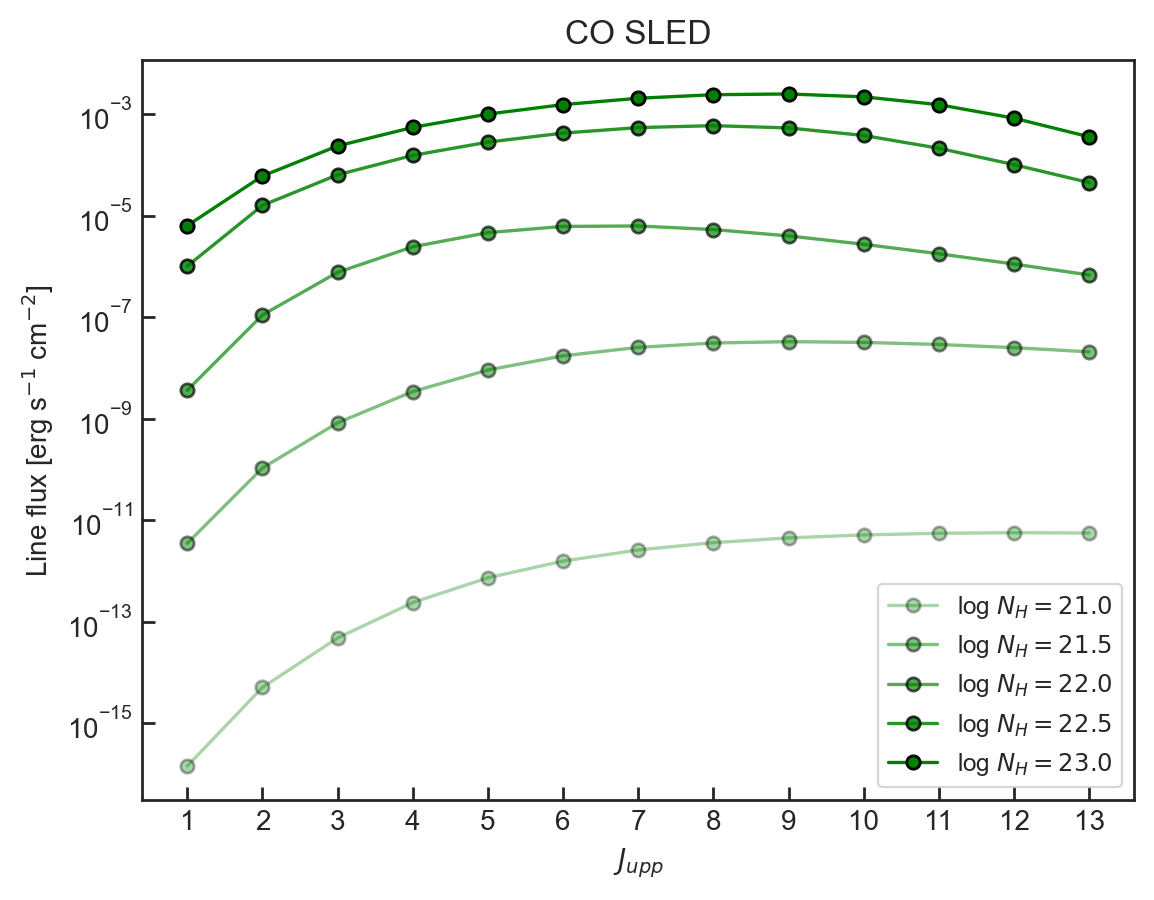

In [303]:
x = np.arange(1, 14)

fig, ax = plt.subplots(1, 1)
ax.set_title('CO SLED')

for logNH in np.arange(21, 23.1, .5):
    i = np.abs(np.log10(pdr['H colden']) - logNH).argmin()
    y = [emis[emisdict['CO%1d' % l]].iloc[i] for l in range(1, 14)]
    ax.plot(x, y, c='g', marker='o', mec='k', label=r'log $N_H = %.1f$' % logNH, alpha=(logNH - 20)/ (23-20))

ax.set_yscale('log')
ax.legend()
ax.set_xticks(x)
ax.set_xlabel('$J_{upp}$')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### Tracing carbon emission

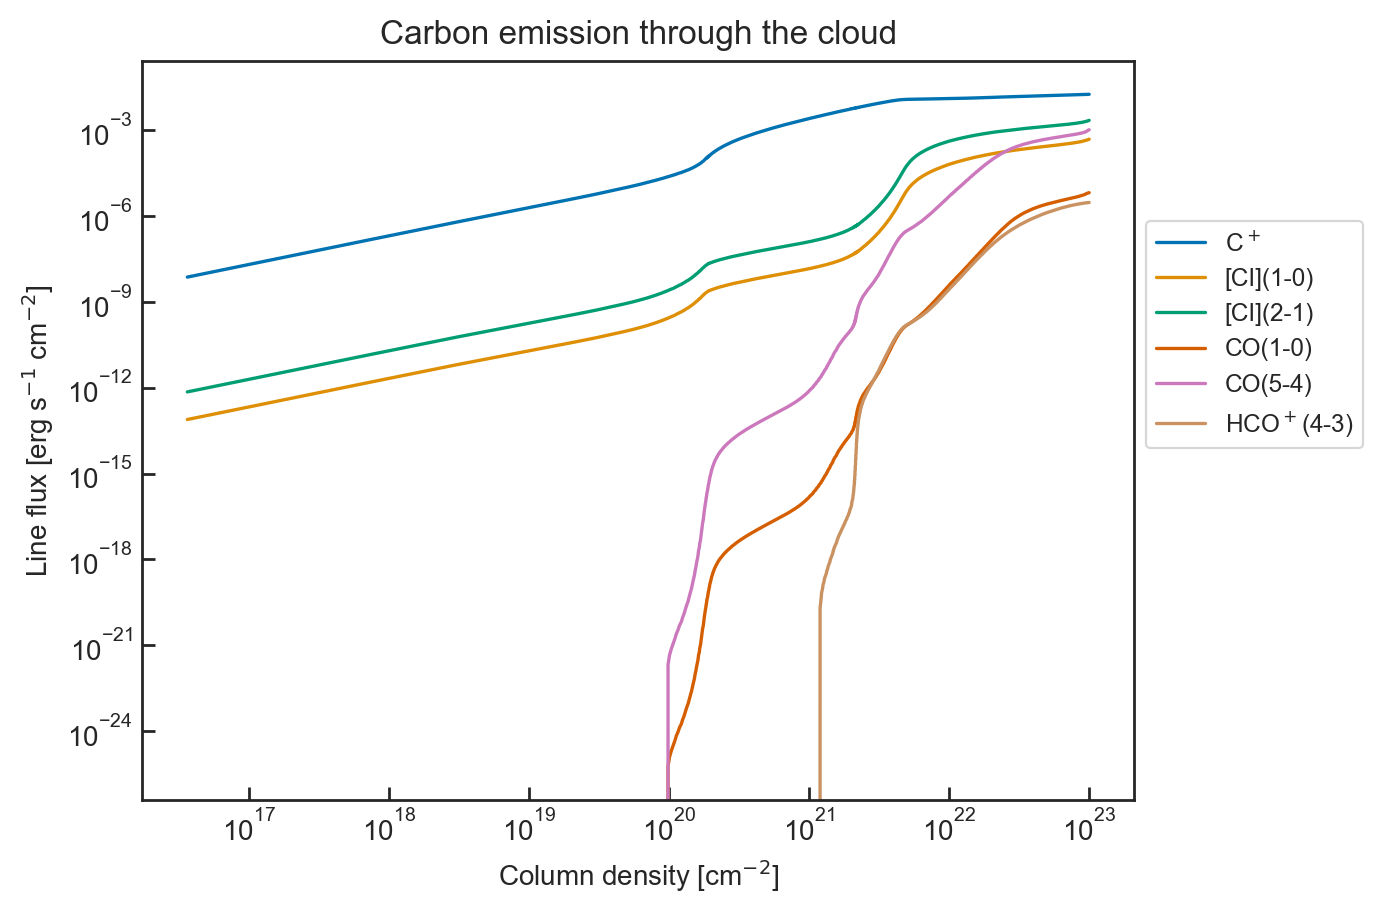

In [304]:
x = pdr['H colden']
lines = ['CII158', 'CI1', 'CI2', 'CO1', 'CO5', 'HCO4']
labs = ['C$^+$', '[CI](1-0)', '[CI](2-1)', 'CO(1-0)', 'CO(5-4)', 'HCO$^+$(4-3)']

fig, ax = plt.subplots(1, 1)
ax.set_title('Carbon emission through the cloud')

for l, lab in zip(lines, labs):
    y = emis[emisdict[l]]
    ax.loglog(x, y, label=lab)

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

### BPT line ratios

In [305]:
emisdict.keys()

dict_keys(['cm', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'CO9', 'CO10', 'CO11', 'CO12', 'CO13', '13CO1', '13CO2', '13CO3', 'HCN1', 'HCN2', 'HCN3', 'HCN4', 'HCN5', 'HCN6', 'HCN7', 'HCN8', 'HCO1', 'HCO2', 'HCO3', 'HCO4', 'HCO5', 'HCO6', 'HCO7', 'HCO8', 'HNC1', 'HNC2', 'HNC3', 'HNC4', 'HNC5', 'HNC6', 'HNC7', 'HNC8', 'CI1', 'CI2', 'CII158', 'OI63', 'OI145', 'OIII88', 'NII205', 'NII122', 'Halpha', 'Hbeta', 'Paalpha', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300'])

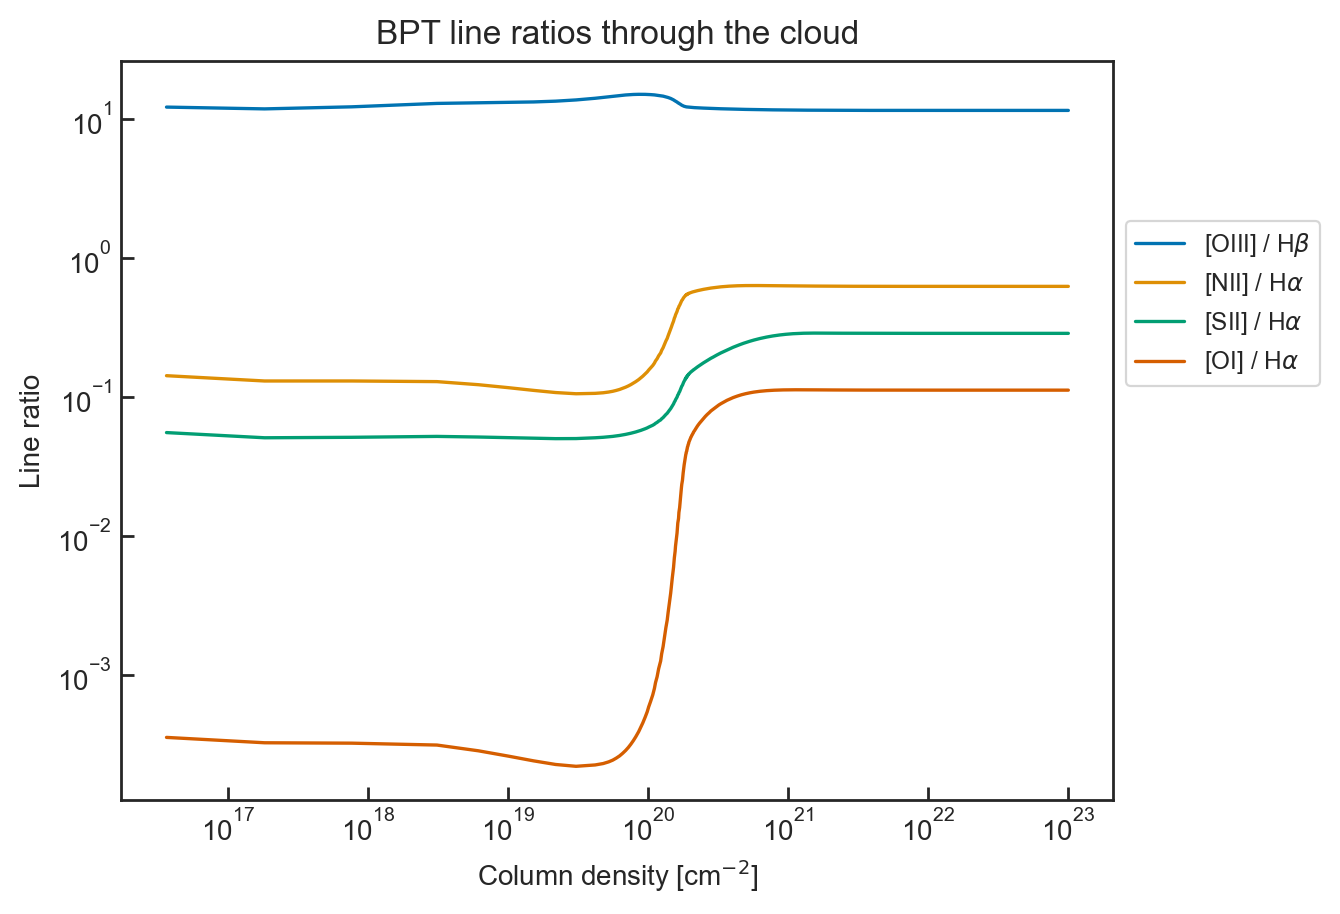

In [306]:
x = pdr['H colden']
r1 = emis[emisdict['[OIII]5007']] / emis[emisdict['Hbeta']]
r2 = emis[emisdict['[NII]6583']] / emis[emisdict['Halpha']]
r3 = emis[emisdict['[SII]6716']] / emis[emisdict['Halpha']]
r4 = emis[emisdict['[OI]6300']] / emis[emisdict['Halpha']]
labs = [r'[OIII] / H$\beta$', r'[NII] / H$\alpha$', r'[SII] / H$\alpha$', r'[OI] / H$\alpha$']

fig, ax = plt.subplots(1, 1)
ax.set_title('BPT line ratios through the cloud')

for r, lab in zip([r1, r2, r3, r4], labs):
    ax.loglog(x, r, label=lab)

ax.legend(bbox_to_anchor=(1, .8))
ax.set_xlabel('Column density [cm$^{-2}$]')
ax.set_ylabel('Line ratio');

### BPT diagram

In [307]:
def kewley01(x):
	if x < 0.47:
		return 0.61 / (x - 0.47) + 1.19
	else:
		return -9 # a high negative number out of the plot

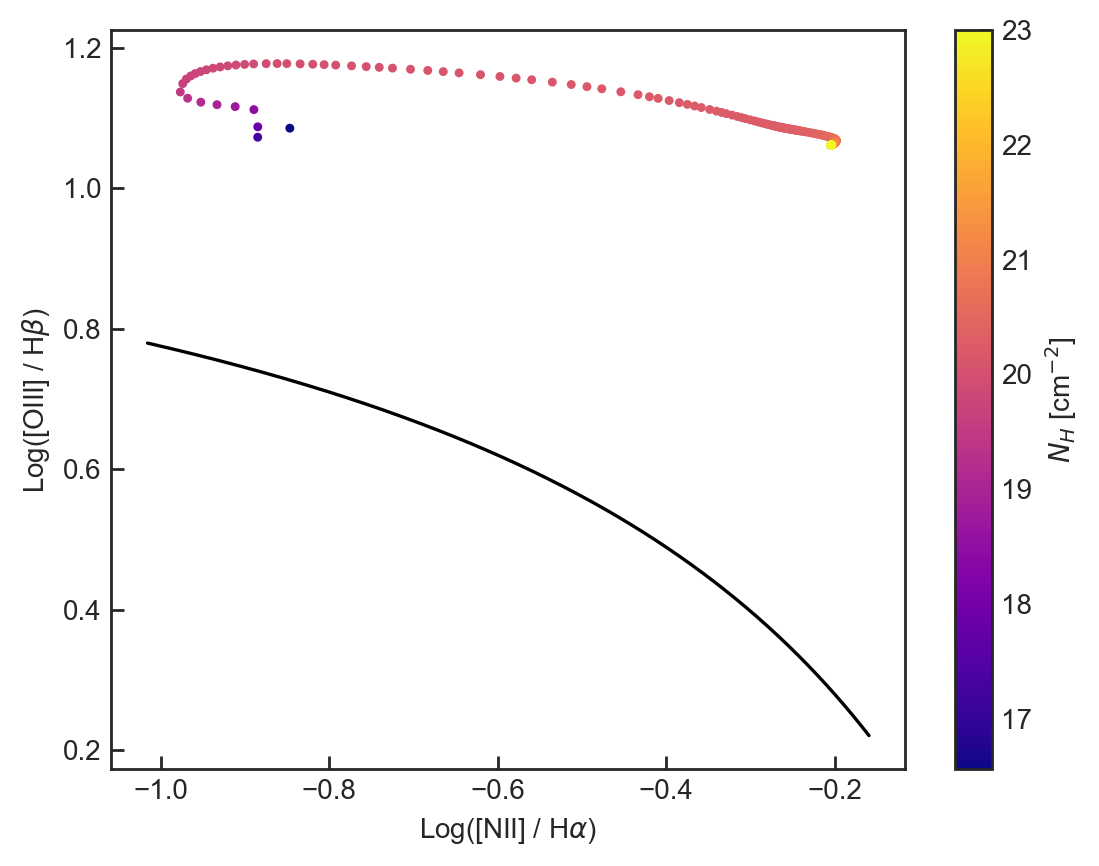

In [308]:
r1 = np.log10(emis[emisdict['[OIII]5007']] / emis[emisdict['Hbeta']])
r2 = np.log10(emis[emisdict['[NII]6583']] / emis[emisdict['Halpha']])
r3 = np.log10(emis[emisdict['[SII]6716']] / emis[emisdict['Halpha']])
r4 = np.log10(emis[emisdict['[OI]6300']] / emis[emisdict['Halpha']])
labs = [r'Log([OIII] / H$\beta$)', r'Log([NII] / H$\alpha$)', r'Log([SII] / H$\alpha$)', r'Log([OI] / H$\alpha$)']

fig, ax = plt.subplots(1, 1)
sp = ax.scatter(r2, r1, marker='.', c=np.log10(pdr['H colden']), cmap='plasma')
cbar = fig.colorbar(sp, ax=ax, label='$N_H$ [cm$^{-2}$]')
ax.set_xlabel(labs[1])
ax.set_ylabel(labs[0])

# theoretical line (Kewley+2001)
xrange = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
ax.plot(xrange, [kewley01(x) for x in xrange], c='k');

# PDR - XDR comparison

In [349]:
prefix = ['../pdr/pdr5_h400_g300', '../xdr/agn5_h400_x000']
ovr = [pd.read_csv(p + '.ovr', sep='\t') for p in prefix]
pdr = [pd.read_csv(p + '.pdr', sep='\t') for p in prefix]
emis = [pd.read_csv(p + '.emis', sep='\t') for p in prefix]

## Gas temperature

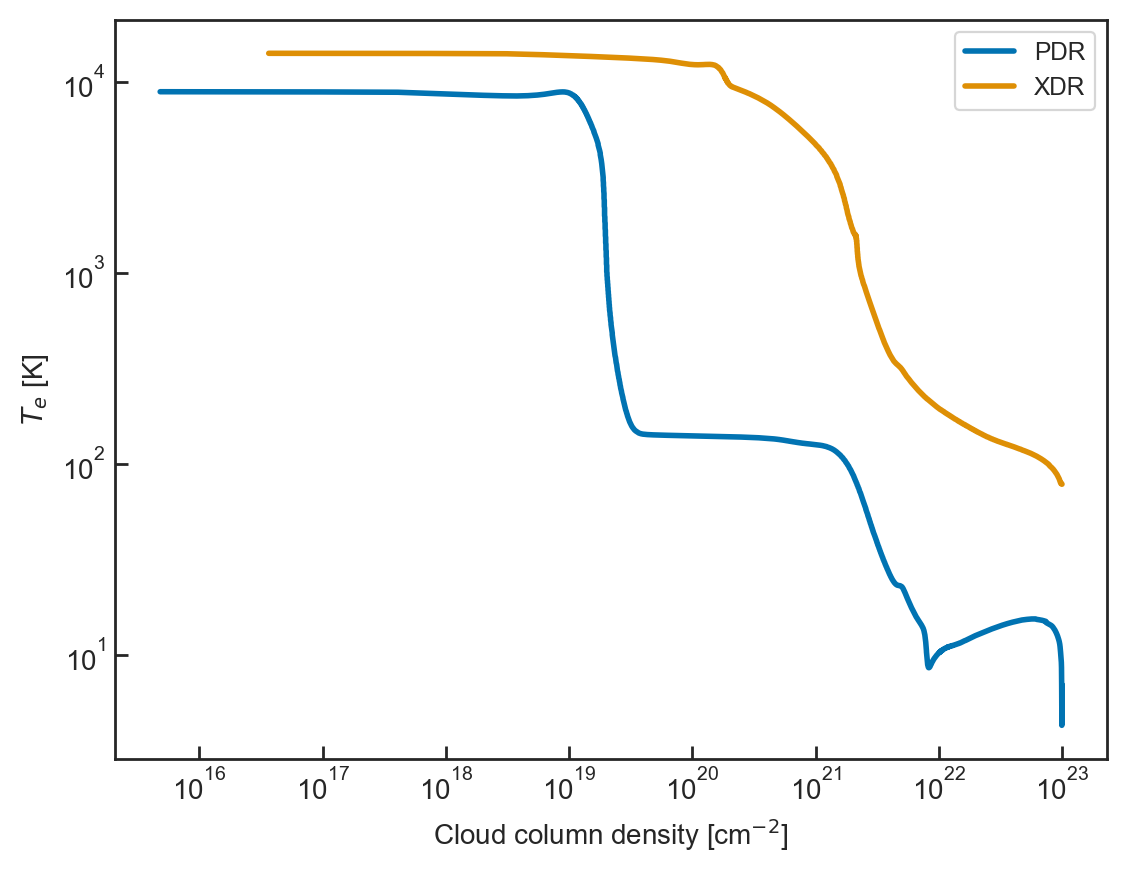

In [319]:
fig, ax = plt.subplots(1, 1)

for i, lab in enumerate(['PDR', 'XDR']):
    x = pdr[i]['H colden']
    y = ovr[i]['Te']
    ax.loglog(x, y, label=lab, lw=2)

ax.legend()
ax.set_xlabel('Cloud column density [cm$^{-2}$]')
ax.set_ylabel('$T_e$ [K]');

## Hydrogen ionization fractions

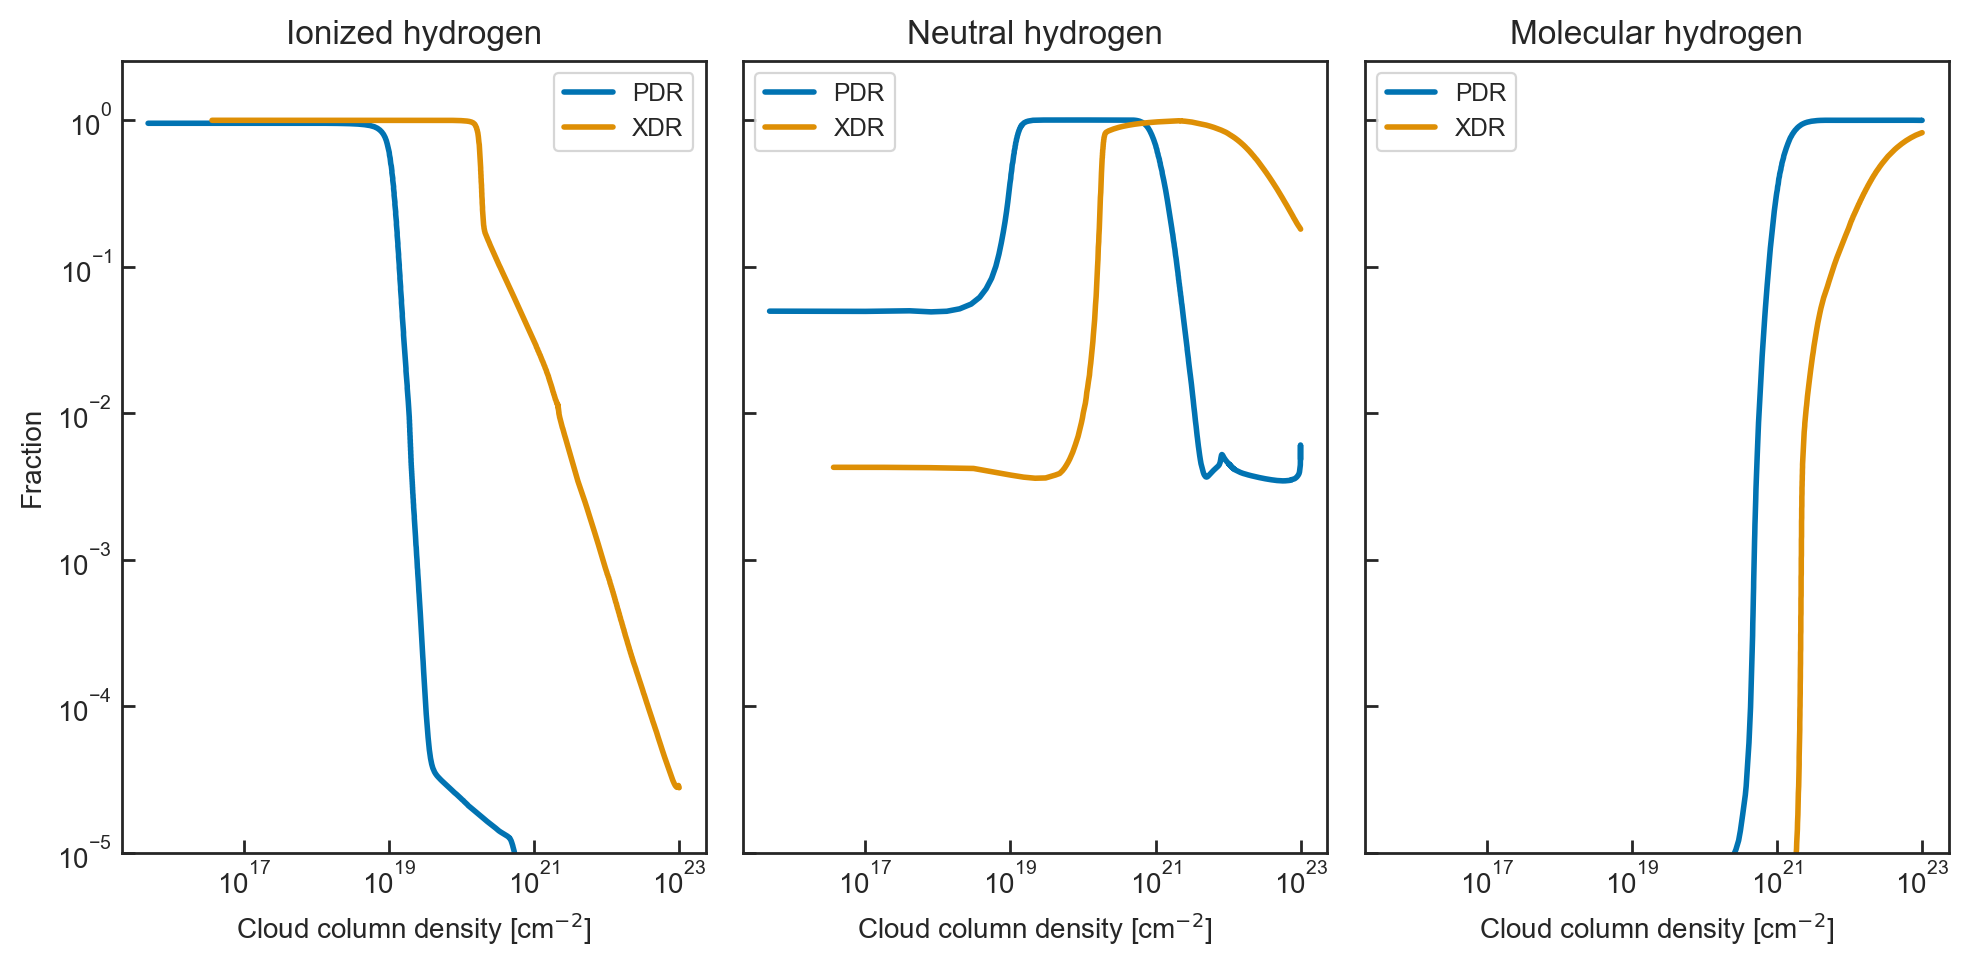

In [320]:
titles = ['Ionized hydrogen', 'Neutral hydrogen', 'Molecular hydrogen']

fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

for ax, col, t in zip(axs.flat, ['HII', 'HI', '2H_2/H'], titles):
    ax.set_title(t)
    
    for i, lab in enumerate(['PDR', 'XDR']):
        x = pdr[i]['H colden']
        y = ovr[i][col]
        ax.loglog(x, y, label=lab, lw=2)
    
    ax.legend()
    ax.set_ylim(bottom=1e-5)
    ax.set_xlabel('Cloud column density [cm$^{-2}$]')
    ax.set_ylabel('Fraction')
    ax.label_outer()
plt.tight_layout();

## Carbon ionization fractions

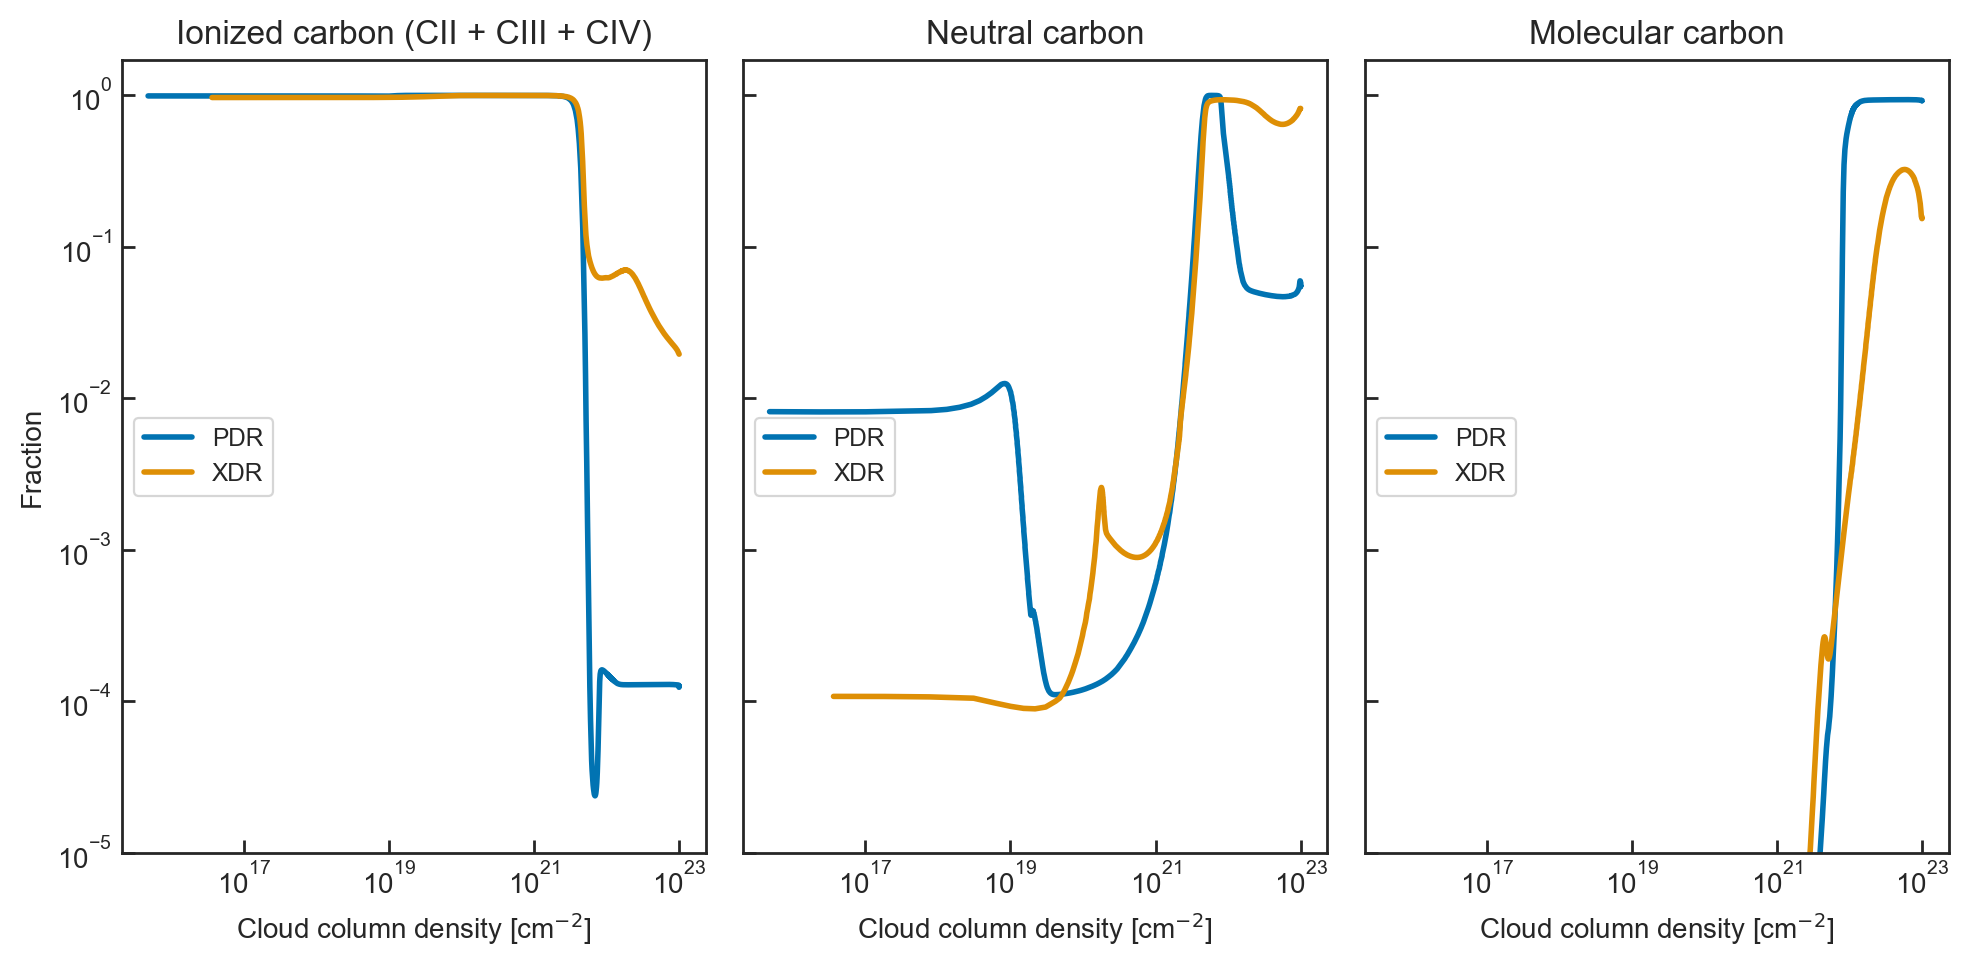

In [321]:
titles = ['Ionized carbon (CII + CIII + CIV)', 'Neutral carbon', 'Molecular carbon']

fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

for ax, col, t in zip(axs.flat, [['C4', 'C3', 'C2'], 'C1', 'CO/C'], titles):
    ax.set_title(t)
    
    for i, lab in enumerate(['PDR', 'XDR']):
        x = pdr[i]['H colden']
        if type(col) == list:
            y = sum([ovr[i][c] for c in col])
        else:
            y = ovr[i][col]
        ax.loglog(x, y, label=lab, lw=2)
    
    ax.legend(loc='center left')
    ax.set_ylim(bottom=1e-5)
    ax.set_xlabel('Cloud column density [cm$^{-2}$]')
    ax.set_ylabel('Fraction')
    ax.label_outer()
plt.tight_layout();

## [OIII]5007 / [CII]158

See Veraldi et al. 2025: [ADS link](https://ui.adsabs.harvard.edu/abs/2025A%26A...693A..34V/abstract)

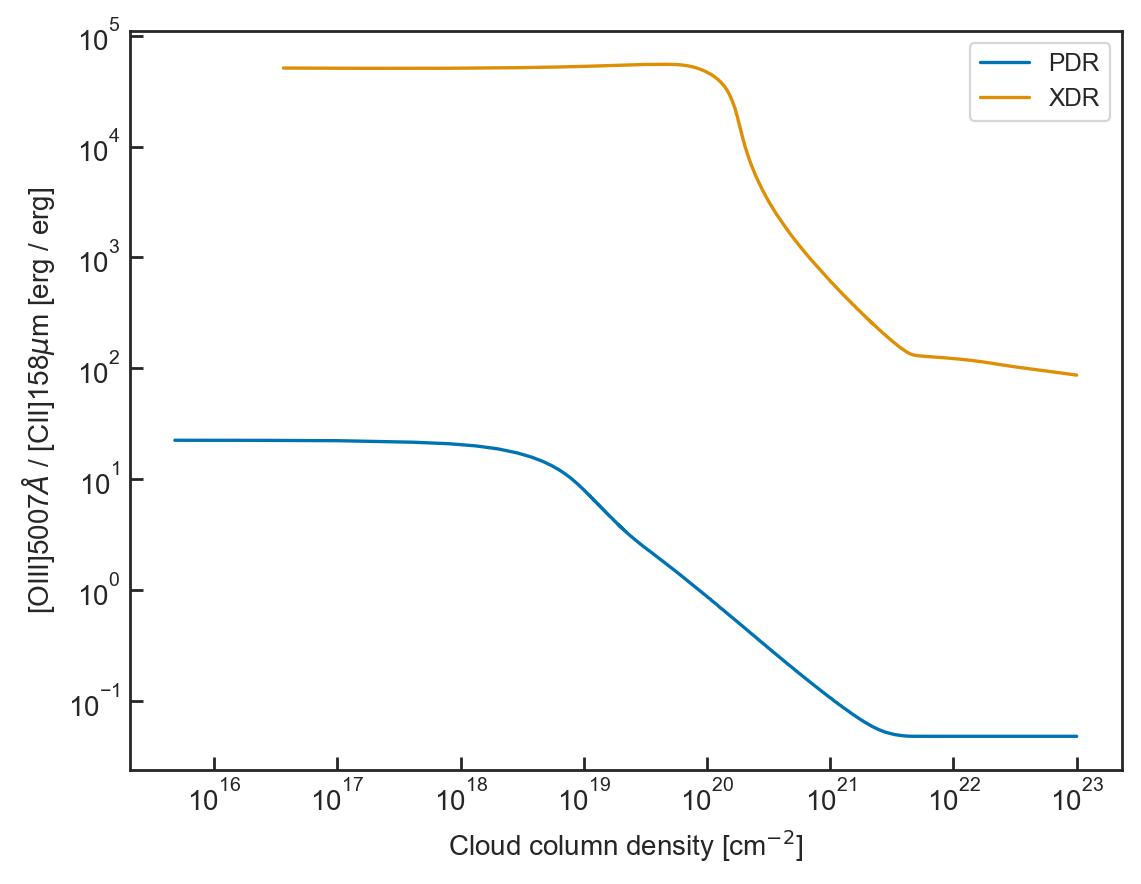

In [351]:
fig, ax = plt.subplots(1, 1)

for i, lab in enumerate(['PDR', 'XDR']):
    x = pdr[i]['H colden']
    y = emis[i][emisdict['[OIII]5007']] / emis[i][emisdict['CII158']]
    ax.loglog(x, y, label=lab)

ax.legend()
ax.set_xlabel('Cloud column density [cm$^{-2}$]')
ax.set_ylabel(r'[OIII]5007$\AA$ / [CII]158$\mu$m [erg / erg]');

## CO SLED

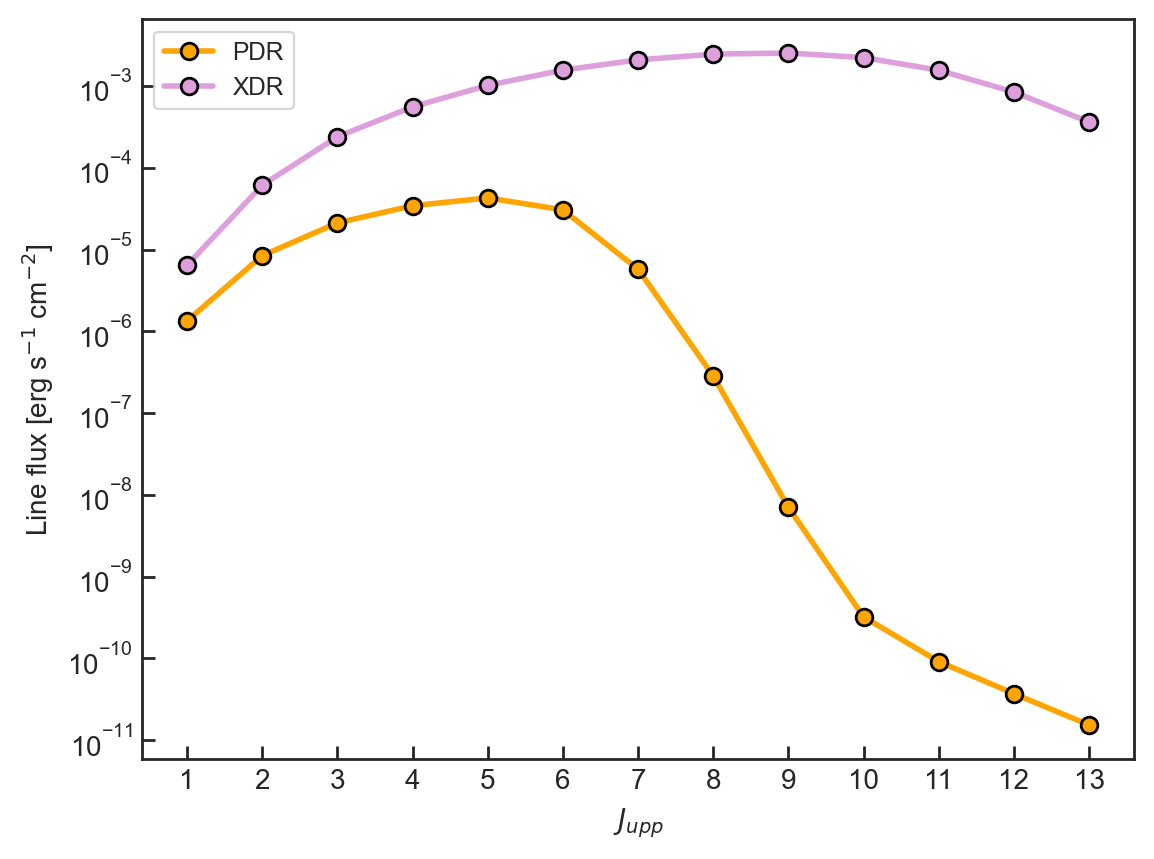

In [345]:
x = np.arange(1, 14)
colors = ['orange', 'plum']

fig, ax = plt.subplots(1, 1)
for i, lab in enumerate(['PDR', 'XDR']):
    y = [emis[i][emisdict['CO%1d' % l]].iloc[-1] for l in range(1, 14)]
    ax.plot(x, y, c=colors[i], marker='o', mec='k', ms=6, label=lab, lw=2)

ax.set_yscale('log')
ax.legend()
ax.set_xticks(x)
ax.set_xlabel('$J_{upp}$')
ax.set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');

# PDR + XDR grid 

In [541]:
# superior directory containing all the files
supdir = '../grid/'

# grid set up (values and naming conventions)
hden = np.array([1, 3, 5, 6.5])
logG0 = np.array([1, 3, 5])
logFX = np.array([-1, 1, 3])
hnames = ['h' + ('%.2f' % h).replace('.', '') for h in hden]
gnames = ['g' + ('%.2f' % g).replace('.', '') for g in logG0]
xnames = ['x' + ('%.2f' % x).replace('.', '') for x in logFX]

print('hnames =', hnames)
print('gnames =', gnames)
print('xnames =', xnames)

hnames = ['h100', 'h300', 'h500', 'h650']
gnames = ['g100', 'g300', 'g500']
xnames = ['x-100', 'x100', 'x300']


In [542]:
gridlabs = ['cm'] + ['CO%1d' % x for x in range(1, 31)] + ['HCN%1d' % x for x in range(1, 8)]
gridlabs += ['HCO%1d' % x for x in range(1, 8)] + ['HNC%1d' % x for x in range(1, 8)]
gridlabs += ['H2O313_220', 'H2O211_202', 'H2O202_111', 'H2O111_000', 'H2O312_303', 'H2O312_221']
gridlabs += ['H2O321_312', 'H2O422_413', 'H2O220_211', 'H2O523_514', 'H2O303_212']
gridlabs += ['13CO1', '13CO2', '13CO3'] + ['CS%1d' % x for x in range(1, 8)]
gridlabs += ['SiO%1d' % x for x in range(1, 6)] + ['H2CO322_221']
gridlabs += ['C2H31_10', 'C2H31_11', 'C2H31_21', 'C2H11_10', 'C2H11_11', 'C2H11_01', 'CN33', 'CN31', 'CN53']
gridlabs += ['CH3OH21a', 'CH3OH21b', 'CH3OH21c', 'CH3OH32a', 'CH3OH32b']
gridlabs += ['OHpm1', 'OHpm2', 'OHpm3', 'OHmp1', 'OHmp2', 'OHmp3']
gridlabs += ['CI1', 'CI2', 'CII158', 'OI63', 'OI145', 'OIII88', 'NII205', 'NII122']
gridlabs += ['Halpha', 'Hbeta', 'Paalpha', '[OIII]5007', '[NII]6583', '[SII]6716', '[OI]6300']
gridlabs += ['H2', 'Fe2', 'Si2', 'H2S0', 'H2S1', 'H2S2', 'H2S3']

# saving the columns from one of the emis files
emis = pd.read_csv(supdir + 'pdr_h100_g100.emis', sep='\t')
griddict = dict(zip(gridlabs, emis.columns))

## CO SLED (fixing the density)

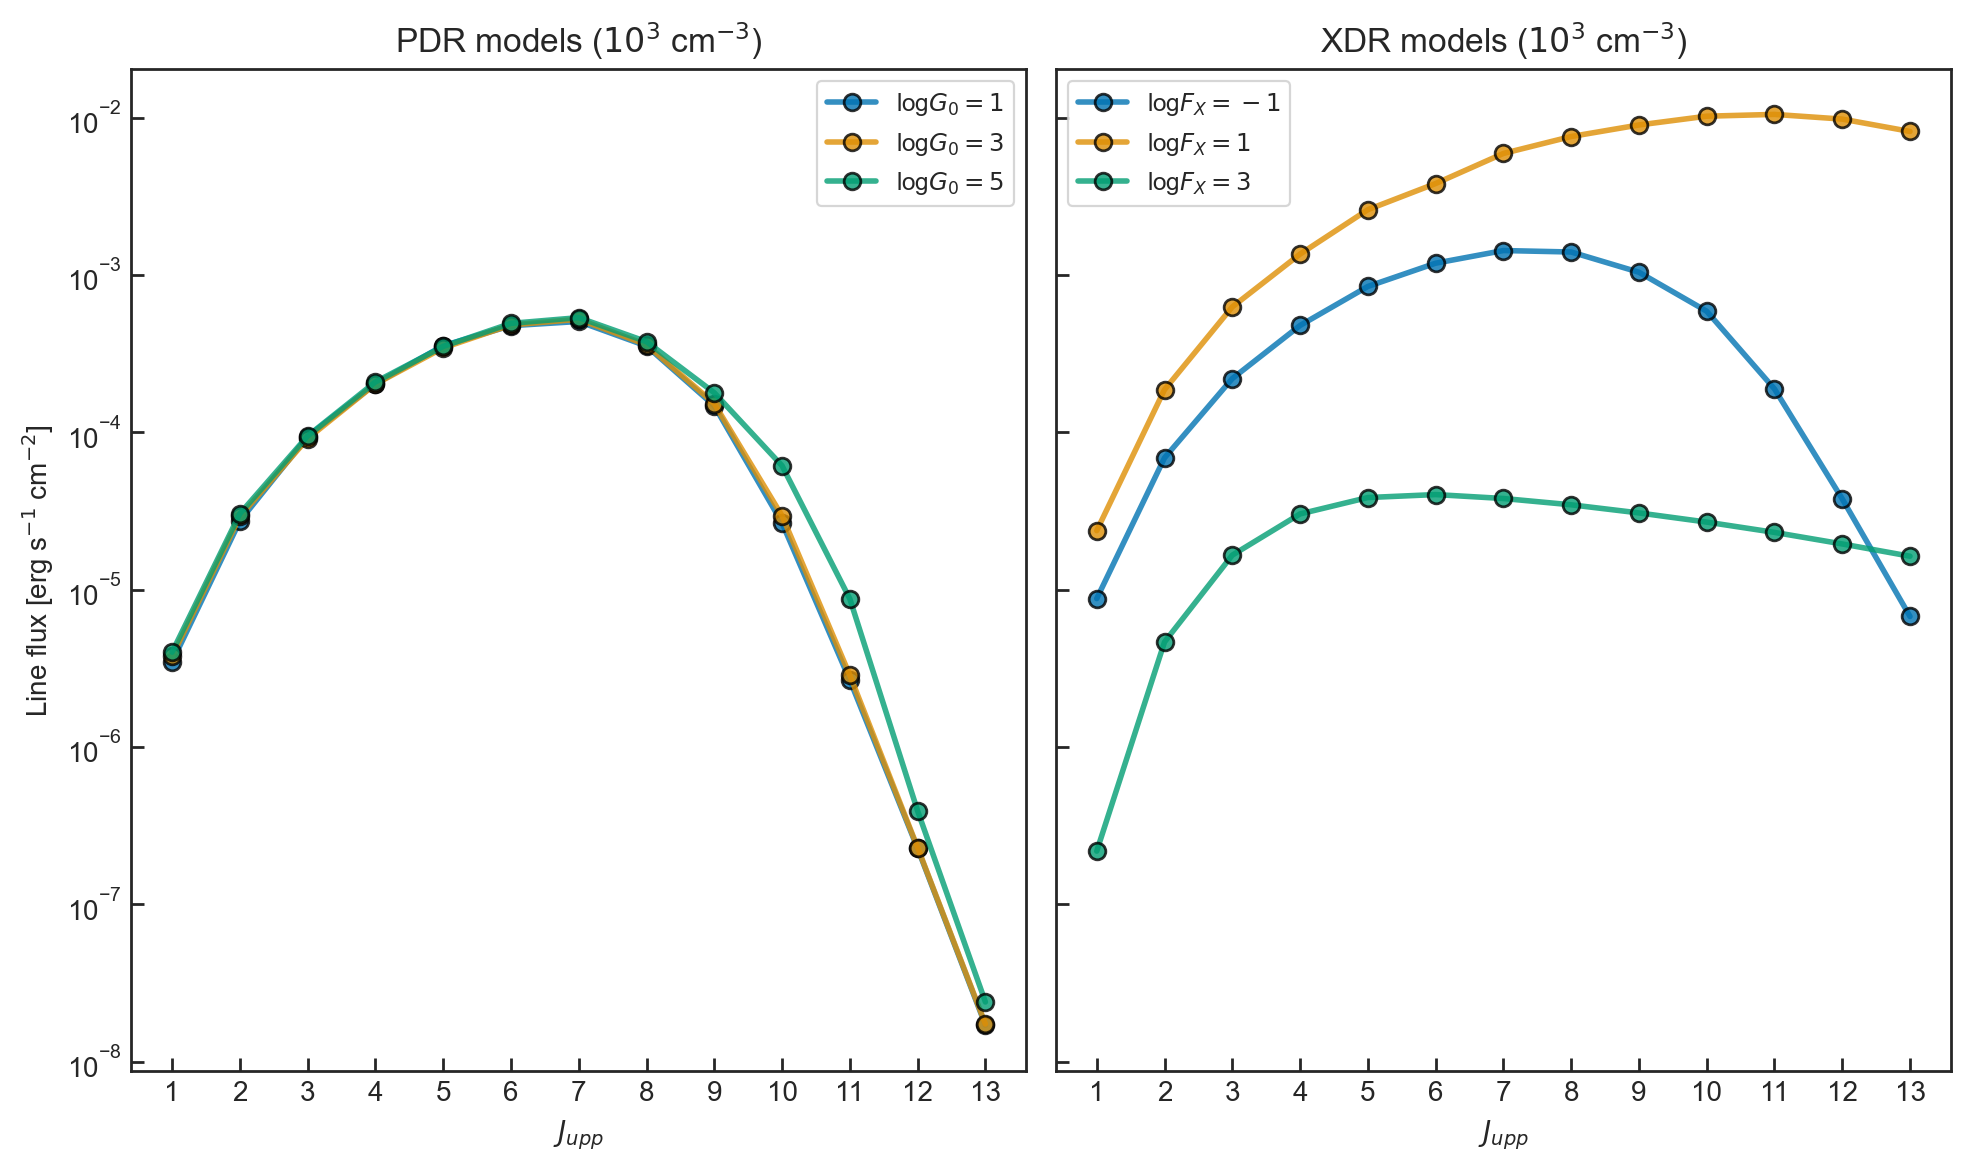

In [543]:
# fixing the gas density
# k=0: hden=1;  k=1: hden=3;  k=2: hden=5;  k=3: hden=6.5
k = 1

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
x = np.arange(1, 14)

# PDR panel
axs[0].set_title('PDR models ($10^{%1d}$ cm$^{-3}$)' % hden[k])
for i in range(3):
    emis = pd.read_csv(supdir + 'pdr_%s_%s.emis' % (hnames[k], gnames[i]), sep='\t')
    y = [emis[griddict['CO%1d' % l]].iloc[-1] for l in range(1, 14)]
    axs[0].plot(x, y, label='log$G_0=%1d$' % logG0[i], marker='o', mec='k', ms=6, lw=2, alpha=.8)

axs[1].set_title('XDR models ($10^{%1d}$ cm$^{-3}$)' % hden[k])
for i in range(3):
    emis = pd.read_csv(supdir + 'xdr_%s_%s.emis' % (hnames[k], xnames[i]), sep='\t')
    y = [emis[griddict['CO%1d' % l]].iloc[-1] for l in range(1, 14)]
    axs[1].plot(x, y, label='log$F_X=%1d$' % logFX[i], marker='o', mec='k', ms=6, lw=2, alpha=.8)

for ax in axs.flat:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xlabel('$J_{upp}$')

axs[0].set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');
plt.tight_layout();

## CO SLED (fixing the incident flux)

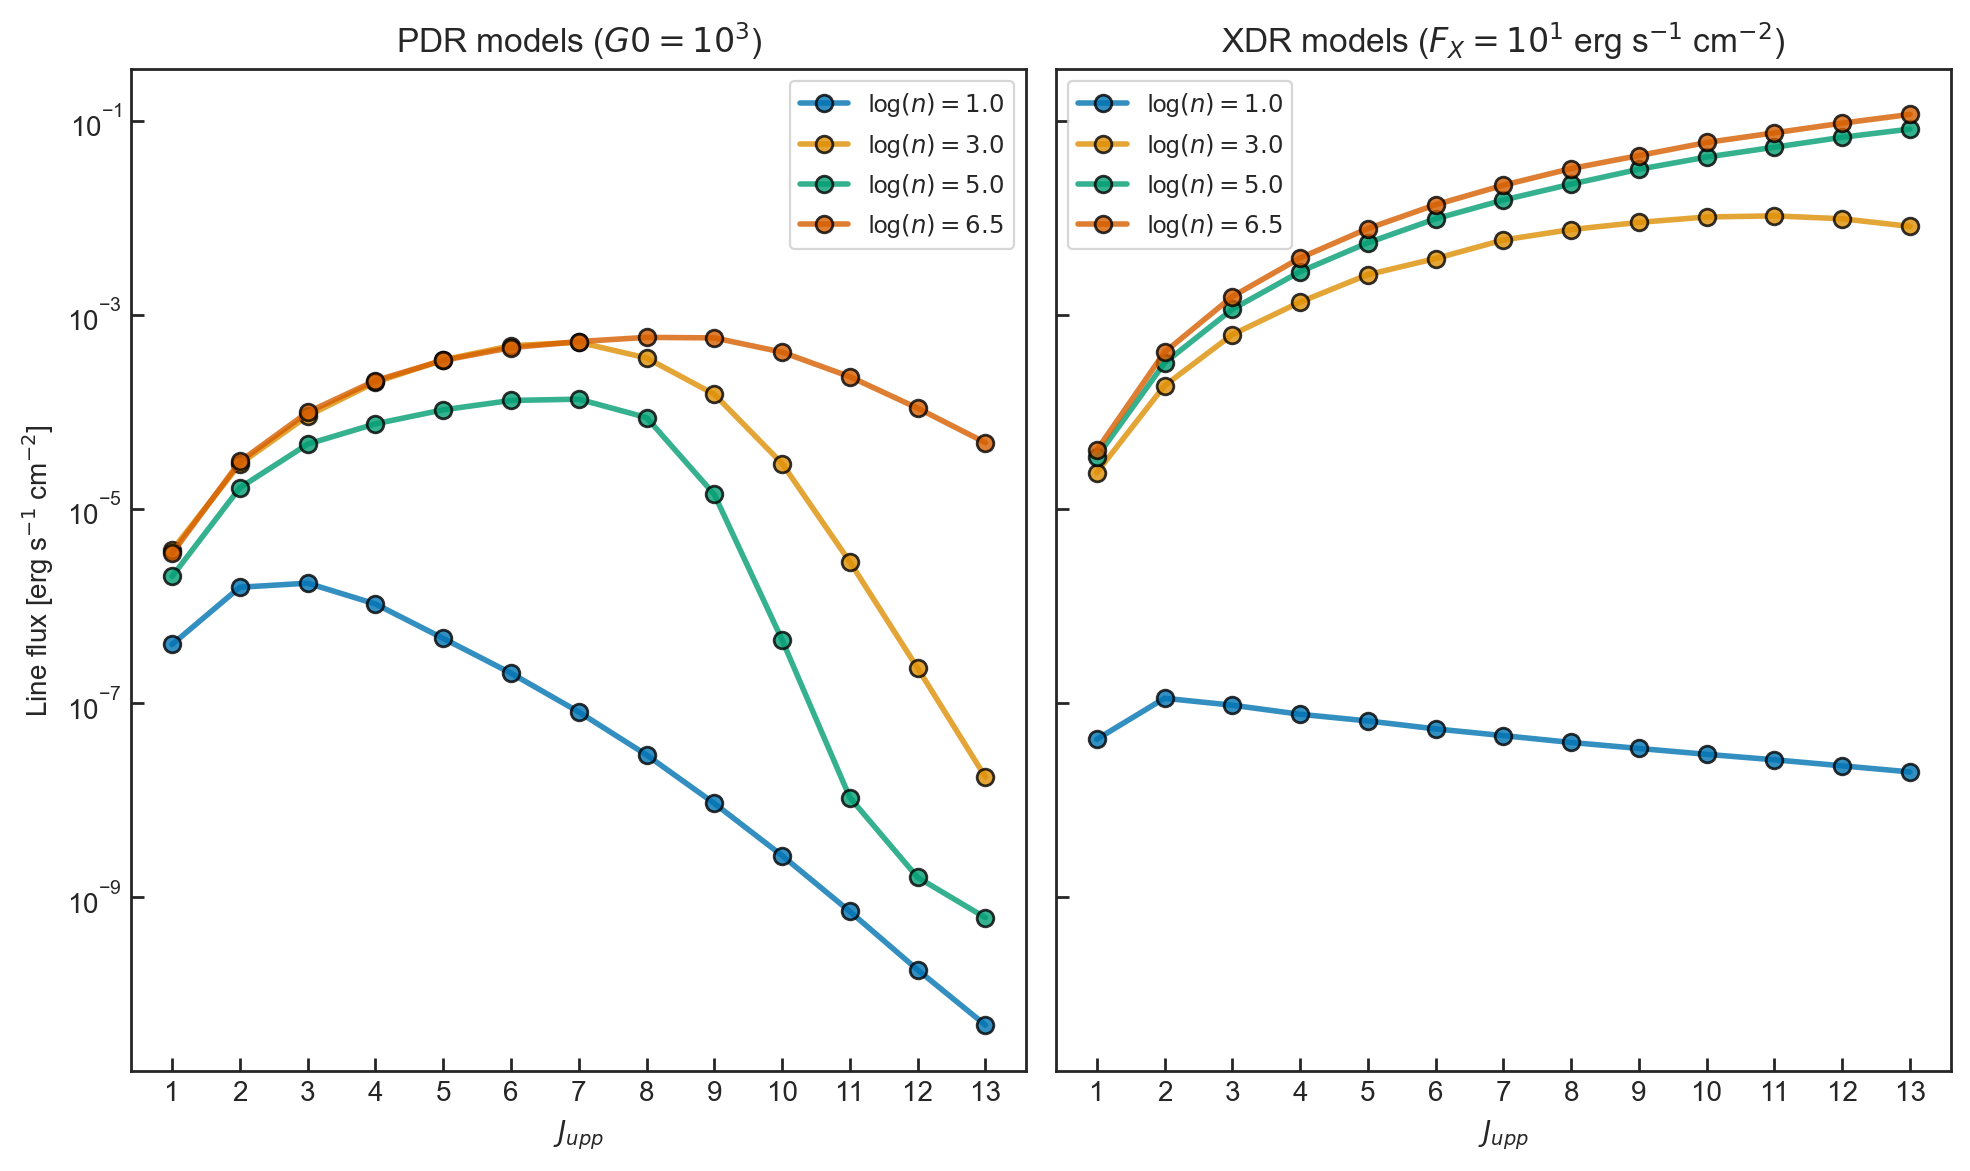

In [545]:
# fixing the gas density
# k=0: low flux;  k=1: medium flux;  k=2: high flux
k = 1

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
x = np.arange(1, 14)

# PDR panel
axs[0].set_title('PDR models ($G0 = 10^{%1d}$)' % logG0[k])
for i in range(4):
    emis = pd.read_csv(supdir + 'pdr_%s_%s.emis' % (hnames[i], gnames[k]), sep='\t')
    y = [emis[griddict['CO%1d' % l]].iloc[-1] for l in range(1, 14)]
    axs[0].plot(x, y, label='log$(n)=%.1f$' % hden[i], marker='o', mec='k', ms=6, lw=2, alpha=.8)

axs[1].set_title('XDR models ($F_X = 10^{%1d}$ erg s$^{-1}$ cm$^{-2}$)' % logFX[k])
for i in range(4):
    emis = pd.read_csv(supdir + 'xdr_%s_%s.emis' % (hnames[i], xnames[k]), sep='\t')
    y = [emis[griddict['CO%1d' % l]].iloc[-1] for l in range(1, 14)]
    axs[1].plot(x, y, label='log$(n)=%.1f$' % hden[i], marker='o', mec='k', ms=6, lw=2, alpha=.8)

for ax in axs.flat:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xlabel('$J_{upp}$')

axs[0].set_ylabel('Line flux [erg s$^{-1}$ cm$^{-2}$]');
plt.tight_layout();

# EXERCISE

Try to interpret observed CO SLEDs of galaxies with PDR and XDR models made with CLOUDY.

## 1. Import the observed dataset
`cloudy_unibo_workshop/data/co_sleds.csv` : a comma-separated-values table of observed CO fluxes for seven galaxies

In [540]:
# your code here

## 2. Choose one galaxy
They are all different

In [539]:
# your code here

## 3. Import the PDR+XDR grid files
See the cells we run in this notebook (section `PDR + XDR grid`)

In [538]:
# your code here

## 4. Use a chi-square minimization
This is the easiest thing one can do to check which model can better reproduce observed data.

$$\Large
\chi^2 = \sum_{i=1}^{13} \left( \frac{O_i - M_i}{\epsilon_i} \right)^2
$$
where $O_i$ is an observed flux with observational error $\epsilon_i$, and $M_i$ is a modelled flux.

See the cell below for a ready-to-use function

In [608]:
def chi_square_SLED(obs_sled, obs_sled_errors, model_sled):
    '''
    INPUT PARAMETERS (values must have the same physical units):
     - obs_sled        = observed data array (13 fluxes or luminosities)
     - obs_sled_errors = absolute data errors (13 fluxes or luminosities)
     - model_sled      = a single-model CO SLED (13 fluxes or luminosities)
    '''
    # converting inputs into numpy arrays
    obs_sled = np.array(obs_sled) if type(obs_sled) == pd.Series else obs_sled
    obs_sled_errors = np.array(obs_sled_errors) if type(obs_sled_errors) == pd.Series else obs_sled_errors
    model_sled = np.array(model_sled) if type(model_sled) == pd.Series else model_sled
    chisqr = 0. 
    for i in range(len(obs_sled)):
        chisqr += (obs_sled[i] - model_sled[i])**2 / obs_sled_errors[i]**2
    return chisqr

In [537]:
# your code here